# Executive Summary

I'm using the environment in the OpenAI gym - Classic Control to practice how to train an agent by reinforcement learning. In this notebook, a car is on a one-dimensional track, positioned between two "mountains". ***The goal is to drive up the mountain reaches the flag on the right***

I try differnet methods to complete this goal:

***1. Create a simple policy (without any learning applied)*** (See Section 4)
- Result: ***The car reaches the flag on the right by only using the simple_policy with 111.8 timesteps spend on average*** 


***2. Create a Deep Learning Model with Keras*** (See Section 5)
##### First Agent's Performance
- Result: The first Agent after training with ***learning rate 1e-4 for 200k training steps***, ***the car reaches the flag on the right with 131.4 timesteps spend on average***, but such performance is not better than the simple policy without any learning.
- loss: 0.309 at the end of the last episode means that we are still able to improve the performance. 

##### Second Agent's Performance
- Result: The second Agent after training with ***learning rate 1e-3 for 500k training teps***, ***the car reaches the flag on the right with 89.4 timesteps spend on average***, which is ***20% timesteps saving than the simple policy*** without any learning and ***32% timesteps saving than the first agent***.
- loss: 0.128 at the end of the last episode



### ***Table of Content:***

1. What is MountainCar
2. Import Dependencies
3. Understanding The Environment
4. Create a Simple Policy (without any Learning to Comlete the Goal)
5. Create a Deep Learning Model with Keras
   - 5.1 Build Agent with Keras-RL
   - 5.2 Train the First Agents
   - 5.3 Train the Second Agent

# 1. What is MountainCar?

<img src='http://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/MountainCarContinuous-v0/poster.jpg' width='250px'/>

A car is on a one-dimensional track, positioned between two "mountains". ***The goal is to drive up the mountain reaches the flag on the right***; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum. 

### Action Space
- There are 3 discrete deterministic actions:


 Num | Observation                                                 | Value | Unit         |
-----|-------------------------------------------------------------|-------|--------------|
 0   | Accelerate to the left                                      | Inf   | position (m) |
 1   | Don't accelerate                                            | Inf   | position (m) |
 2   | Accelerate to the right                                     | Inf   | position (m) |

 
### Observation Space
The observation space is a 2-dim vector:
- the 1st element represents the "car position" 
- the 2nd element represents the "car velocity"


 Num | Observation                                                 | Min                | Max  | Unit         |
-----|-------------------------------------------------------------|--------------------|------|--------------|
 0   | position of the car along the x-axis                        | -Inf               | Inf  | position (m) |
 1   | velocity of the car                                         | -Inf               | Inf  | position (m) |
 
### Rewards
***The goal is to reach the flag placed on top of the right hill as quickly as possible***, as such the agent is penalised with a ***reward of -1 for each timestep it isn't at the goal*** and is ***not penalised (reward = 0) for when it reaches the goal***.

### Transition Dynamics:
Given an action, the mountain car follows the following transition dynamics:
- *velocity<sub>t+1</sub> = velocity<sub>t</sub> + (action - 1) * force - cos(3 * position<sub>t</sub>) * gravity*
- *position<sub>t+1</sub> = position<sub>t</sub> + velocity<sub>t+1</sub>* where force = 0.001 and gravity = 0.0025.

- The collisions at either end are inelastic with the velocity set to 0 upon collision with the wall. 
- The position is clipped to the range `[-1.2, 0.6]` and velocity is clipped to the range `[-0.07, 0.07]`.


### Episode Termination
The episode terminates if either of the following happens:
1. The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
2. The length of the episode is 200.

### Gym interface
The three main methods of an environment are:
* `reset()`: reset environment to the initial state, _return first observation_
* `render()`: show current environment state
* `step(a)`: commit action `a` and return `(new_observation, reward, is_done, info)`
 * `new_observation`: an observation right after committing the action `a`
 * `reward`: a number representing your reward for committing action `a`
 * `is_done`: True if the MDP has just finished, False if still in progress
 * `info`: some auxiliary stuff about what just happened. For now, ignore it.

# 2. Import Dependencies

2022-03-17 16:03:07.388 python[1030:16639] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f9ea4f27720>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-17 16:03:07.389 python[1030:16639] Warning: Expected min height of view: (<NSButton: 0x7f9ea3d68080>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-17 16:03:07.391 python[1030:16639] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f9ea3d6ac90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-17 16:03:07.393 python[1030:16639] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f9ea3d96dc0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)


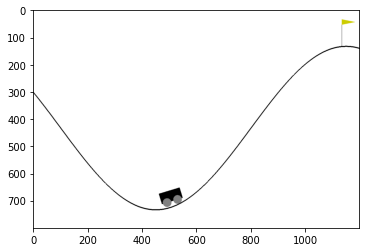

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("MountainCar-v0")                       # Using MountainCar verion 0 in this notebook
env.reset()                                            # reset the environment to initial default

plt.imshow(env.render('rgb_array'))                    # display the environment
print("Observation space:", env.observation_space)     # position: [-1.2, 0.6], velocity: [-0.07, 0.07] - [lower bound, upper bound]
print("Action space:", env.action_space)               # 3 actions could be taken in this environment: Accelerate to left, Don't accelerate, Acelerate to right 

In [2]:
env.close                                    # close the opened environment 

<bound method Wrapper.close of <TimeLimit<MountainCarEnv<MountainCar-v0>>>>

# 3. Understanding The Environment

In [3]:
obs = env.reset()
print("initial observation code:", obs)

# Note: in MountainCar, observation is just two numbers: car position and velocity

initial observation code: [-0.51635909  0.        ]


In [4]:
# If an action 2: acelerate to right is given into the environment
new_obs, reward, is_done, _ = env.step(2)

print("taking action 2 (right)")

# Then the environment will reply 3 things new_observation, reward and is_done to the agent
print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)

# Note: the car has moved to the right slightly (from -0.4775 to -0.4769 around 0.001 moved to right)

taking action 2 (right)
new observation code: [-0.51541338  0.00094571]
reward: -1.0
is game over?: False


### Project Baseline Use Random Action

In [7]:
%%time
episodes = 5

for episode in range(1, episodes + 1):                     # looping from 1 to 5
    
    obs = env.reset()                                      # initial the set of observation
    
    done = False                                           # initial the game is over = False, until reach maximum number of steps in this particular environment
    
    score = 0                                              # running score counter
    
    timesteps_counter = 0                                  # count the number of timestep spend
    
    while not done:
        
        env.render()                                       # view the graphical representation that environment
        
        action = env.action_space.sample()                 # random choose an action 
        
        n_obs, reward, done, info = env.step(action)       # pass random actions into environment to get back
                                                            # 1. next set of observation (4 observation in this case)
                                                            # 2. reward (Positive value increment, negative value decrement)
                                                            # 3. done (episode is done = True)
        
        score += reward                                    # accumulate each episodes' reward received into score
        
        timesteps_counter += 1                             # +1 in each timestep spend
        
    print('Episode:{} Score:{} Timesteps Spend:{}'.format(episode, score,timesteps_counter))    # print out score for each episode

Episode:1 Score:-200.0 Timesteps Spend:200
Episode:2 Score:-200.0 Timesteps Spend:200
Episode:3 Score:-200.0 Timesteps Spend:200
Episode:4 Score:-200.0 Timesteps Spend:200
Episode:5 Score:-200.0 Timesteps Spend:200
CPU times: user 586 ms, sys: 106 ms, total: 692 ms
Wall time: 747 ms


Remark: 
- The above 5 episode showing that, by the end of each episode (length per episode is 200). ***The car would not be able to drive up the mountain reaches the flag on the right by only choosing random actions*** 

# 4. Create a Simple Policy (without any Learning to Comlete the Goal)

So, now let's create a simply policy (without any learning) to drive up the mountain reaches the flag on the right.
- Use the observation (a tuple of position and velocity) to make a swing go farther and faster.

In [9]:
# Define 3 actions as Dictionary
actions = {'Accelerate to left': 0, 'stop': 1, 'Acelerate to right': 2}      

# Define a policy
def simple_policy(obs):
    
    position, velocity = obs                                # observe current postion and velocity

    if velocity > 0:                                        # if current velocity is positive
        return actions['Acelerate to right']                # the policy return an actions 'Accelerate to right' 

    if velocity < 0:                                        # if current velocity is negative
        return actions['Accelerate to left']                # the policy choose an actions 'Accelerate to left'
    
    else:                                                   # if current velocit is 0
        return actions['stop']                              # the policy choose an actions 'stop' the car

### Evaluate the Simple Policy

In [10]:
%%time
episodes = 5

for episode in range(1, episodes + 1):                     # looping from 1 to 5
    
    obs = env.reset()                                      # initial the set of observation
    
    done = False                                           # initial the game is over = False, until reach maximum number of steps in this particular environment
    
    score = 0                                              # running score counter
    
    timesteps_counter = 0                                  # count the number of timestep spend
    
    while not done:
        
        env.render()                                       # view the graphical representation that environment
        
        action = simple_policy(obs)                        # random choose an action 
        
        obs, reward, done, info = env.step(action)       # pass random actions into environment to get back
                                                            # 1. next set of observation (4 observation in this case)
                                                            # 2. reward (Positive value increment, negative value decrement)
                                                            # 3. done (episode is done = True)
        
        score += reward                                    # accumulate each episodes' reward received into score
        
        timesteps_counter += 1                             # +1 in each timestep spend
        
    print('Episode:{} Score:{} Timesteps Spend:{}'.format(episode, score,timesteps_counter))    # print out score for each episode

Episode:1 Score:-115.0 Timesteps Spend:115
Episode:2 Score:-118.0 Timesteps Spend:118
Episode:3 Score:-114.0 Timesteps Spend:114
Episode:4 Score:-119.0 Timesteps Spend:119
Episode:5 Score:-93.0 Timesteps Spend:93
CPU times: user 309 ms, sys: 57.2 ms, total: 366 ms
Wall time: 404 ms


Remark: 
- The above 5 episode showing that, ***The car reaches the flag on the right by only using the simple_policy with 111.8 timesteps spend on average*** 

# 5. Create a Deep Learning Model with Keras

In [12]:
# Import Dependencies
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [13]:
# Build a Sequential Model
def build_model(states, actions):
    
    model = Sequential()
    
    model.add(Flatten(input_shape = (1, states), name = 'States'))      # use Flatten layer as the input layer, input_shape = 1 x number of state 
    
    model.add(Dense(512, activation = 'relu', name = 'Dense_1'))         # use Dense layer with 512 units of tensor with relu activation function
    
    model.add(Dense(256, activation = 'relu', name = 'Dense_2'))         # use another Dense layer with 256 units of tensor with relu activation function
    
    model.add(Dense(actions, activation = 'linear', name = 'Actions'))  # use third Dense as the out layer, output shape = number of actions with linear activation function
    
    return model                                                        # build_model return a model

In [20]:
del model

In [21]:
# Set the input_shape of the build_model function
states = env.observation_space.shape[0]                         # use .shape[0] to return number of observation space

# Set the output_shape of the build_model function
actions = env.action_space.n                                    # use .n to return number of action

# Run the build_model function to build the model
model = build_model(states, actions)                            

# See the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
States (Flatten)             (None, 2)                 0         
_________________________________________________________________
Dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
Dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
Actions (Dense)              (None, 3)                 771       
Total params: 133,635
Trainable params: 133,635
Non-trainable params: 0
_________________________________________________________________


# 5.1 Build Agent with Keras-RL

***Two Types of Policy in Reinforcement Learning (RL):***
1. Value Base RL
2. Policy Base RL 

In [22]:
# Import Dependencies
from rl.agents import DQNAgent                                                      # used DQNAgent here, should try other agents: SARSAAgent      
from rl.policy import BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy      # used Policy base RL  
from rl.memory import SequentialMemory
import os

In [23]:
# Build an Agent to learn from the model
def build_agent(model, actions):            
    
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),    # use EpsGreedyQPolicy()
                                  attr='eps',
                                  value_max = 1,
                                  value_min = .1,
                                  value_test = 0.2,
                                  nb_steps = 10000
    )                    

    memory = SequentialMemory(limit = 1000,              # buffer limit: number of episode
                              window_length = 1          # store pass 1 window for 1000 episode 
                             )
    
    dqn = DQNAgent(model = model, 
                   memory = memory,
                   policy = policy,
                   enable_dueling_network = True,        # Dueling Networks split value and advantage, help the model learn when to take action and when not to bother
                   dueling_type = 'avg',
                   nb_actions = actions,                 # 3 actions to learn
                   nb_steps_warmup = 1000,           
                   target_model_update = 1e-2
                  )
    
    return dqn

# 5.2 Train the First Agent

In [24]:
# set the path to save the log
log_path = os.path.join("Training", "Logs", "MountainCar-v0_Keras-RL")

In [25]:
%%time
# run the build_agent function to traing the agent
agent = build_agent(model, actions)                      # used build_agent to setup a dqn model

agent.compile(Adam(learning_rate = 1e-4),                # use Adam optimisation with learning rate 0.0001
            metrics = ['mae']                            # use mean absolute error to evaluate the metric
           )      

history = agent.fit(env, 
        nb_steps = 200000,                               # number of timesteps 
        visualize = False,                               # visualize during the training
        verbose = 2                                      # how to show the training output
       )

Training for 200000 steps ...
    200/200000: episode: 1, duration: 0.143s, episode steps: 200, steps per second: 1403, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.945 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    400/200000: episode: 2, duration: 0.095s, episode steps: 200, steps per second: 2104, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.875 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    600/200000: episode: 3, duration: 0.090s, episode steps: 200, steps per second: 2224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.975 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    800/200000: episode: 4, duration: 0.094s, episode steps: 200, steps per second: 2138, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.115 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   1000/200000: episode: 5, duration: 0.092s, episode steps: 200, steps per second: 2177, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.140 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   1200/200000: episode: 6, duration: 1.286s, episode steps: 200, steps per second: 155, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.985 [0.000, 2.000],  loss: 0.139418, mae: 0.715063, mean_q: -0.827640, mean_eps: 0.901000
   1400/200000: episode: 7, duration: 0.885s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.985 [0.000, 2.000],  loss: 0.013064, mae: 1.738857, mean_q: -2.543445, mean_eps: 0.883045
   1600/200000: episode: 8, duration: 0.886s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.985 [0.000, 2.000],  loss: 0.029993, mae: 2.822795, mean_q: -4.167069, mean_eps: 0.865045
   1800/200000: episode: 9, duration: 0.884s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.080 [0.000, 2.000],  loss: 0.078236, mae: 3.938225, mean_q

   7600/200000: episode: 38, duration: 0.901s, episode steps: 200, steps per second: 222, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.755 [0.000, 2.000],  loss: 4.395757, mae: 24.784417, mean_q: -36.618443, mean_eps: 0.325045
   7800/200000: episode: 39, duration: 0.906s, episode steps: 200, steps per second: 221, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.095 [0.000, 2.000],  loss: 4.833337, mae: 25.115788, mean_q: -37.157150, mean_eps: 0.307045
   8000/200000: episode: 40, duration: 0.898s, episode steps: 200, steps per second: 223, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.370 [0.000, 2.000],  loss: 2.706774, mae: 25.543455, mean_q: -37.939907, mean_eps: 0.289045
   8200/200000: episode: 41, duration: 0.893s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.935 [0.000, 2.000],  loss: 3.626161, mae: 25.868

  14000/200000: episode: 70, duration: 0.921s, episode steps: 200, steps per second: 217, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.885 [0.000, 2.000],  loss: 4.822670, mae: 33.763752, mean_q: -50.125878, mean_eps: 0.100000
  14200/200000: episode: 71, duration: 0.900s, episode steps: 200, steps per second: 222, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.905 [0.000, 2.000],  loss: 6.200498, mae: 34.154759, mean_q: -50.631778, mean_eps: 0.100000
  14400/200000: episode: 72, duration: 0.919s, episode steps: 200, steps per second: 218, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.905 [0.000, 2.000],  loss: 8.437739, mae: 34.454089, mean_q: -50.862922, mean_eps: 0.100000
  14600/200000: episode: 73, duration: 0.893s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.830 [0.000, 2.000],  loss: 7.355672, mae: 34.625

  20400/200000: episode: 102, duration: 0.891s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.265 [0.000, 2.000],  loss: 8.144292, mae: 38.217694, mean_q: -56.742116, mean_eps: 0.100000
  20600/200000: episode: 103, duration: 0.900s, episode steps: 200, steps per second: 222, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.195 [0.000, 2.000],  loss: 9.128014, mae: 38.158824, mean_q: -56.655801, mean_eps: 0.100000
  20800/200000: episode: 104, duration: 0.888s, episode steps: 200, steps per second: 225, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.920 [0.000, 2.000],  loss: 7.754308, mae: 37.949712, mean_q: -56.305938, mean_eps: 0.100000
  21000/200000: episode: 105, duration: 0.878s, episode steps: 200, steps per second: 228, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.925 [0.000, 2.000],  loss: 6.642659, mae: 37

  26800/200000: episode: 134, duration: 0.878s, episode steps: 200, steps per second: 228, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.190 [0.000, 2.000],  loss: 5.257500, mae: 38.604941, mean_q: -57.528828, mean_eps: 0.100000
  27000/200000: episode: 135, duration: 0.890s, episode steps: 200, steps per second: 225, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.730 [0.000, 2.000],  loss: 7.610494, mae: 38.761819, mean_q: -57.581711, mean_eps: 0.100000
  27200/200000: episode: 136, duration: 0.885s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.575 [0.000, 2.000],  loss: 8.324044, mae: 38.851743, mean_q: -57.713230, mean_eps: 0.100000
  27400/200000: episode: 137, duration: 0.890s, episode steps: 200, steps per second: 225, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.320 [0.000, 2.000],  loss: 9.824375, mae: 38

  33200/200000: episode: 166, duration: 0.884s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.670 [0.000, 2.000],  loss: 10.192335, mae: 41.819849, mean_q: -62.059781, mean_eps: 0.100000
  33400/200000: episode: 167, duration: 0.897s, episode steps: 200, steps per second: 223, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.630 [0.000, 2.000],  loss: 7.712550, mae: 41.850534, mean_q: -62.302995, mean_eps: 0.100000
  33600/200000: episode: 168, duration: 0.883s, episode steps: 200, steps per second: 227, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.855 [0.000, 2.000],  loss: 11.035535, mae: 41.927961, mean_q: -62.297741, mean_eps: 0.100000
  33800/200000: episode: 169, duration: 0.905s, episode steps: 200, steps per second: 221, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.850 [0.000, 2.000],  loss: 8.822632, mae: 

  39600/200000: episode: 198, duration: 0.899s, episode steps: 200, steps per second: 222, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.150 [0.000, 2.000],  loss: 9.214097, mae: 42.125906, mean_q: -62.609618, mean_eps: 0.100000
  39800/200000: episode: 199, duration: 0.887s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.065 [0.000, 2.000],  loss: 9.222167, mae: 42.216849, mean_q: -62.659197, mean_eps: 0.100000
  40000/200000: episode: 200, duration: 0.906s, episode steps: 200, steps per second: 221, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.110 [0.000, 2.000],  loss: 11.363277, mae: 42.245787, mean_q: -62.589641, mean_eps: 0.100000
  40200/200000: episode: 201, duration: 0.886s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.135 [0.000, 2.000],  loss: 11.998490, mae: 

  46000/200000: episode: 230, duration: 0.888s, episode steps: 200, steps per second: 225, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.420 [0.000, 2.000],  loss: 8.895026, mae: 41.654576, mean_q: -61.826871, mean_eps: 0.100000
  46200/200000: episode: 231, duration: 0.892s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.145 [0.000, 2.000],  loss: 6.942946, mae: 41.590135, mean_q: -61.727621, mean_eps: 0.100000
  46400/200000: episode: 232, duration: 0.894s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.440 [0.000, 2.000],  loss: 9.822652, mae: 41.262062, mean_q: -61.215752, mean_eps: 0.100000
  46600/200000: episode: 233, duration: 0.883s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.245 [0.000, 2.000],  loss: 8.864807, mae: 41

  52400/200000: episode: 262, duration: 0.886s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.075 [0.000, 2.000],  loss: 11.059145, mae: 40.601700, mean_q: -59.942536, mean_eps: 0.100000
  52600/200000: episode: 263, duration: 0.891s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.115 [0.000, 2.000],  loss: 8.735842, mae: 40.542620, mean_q: -59.974246, mean_eps: 0.100000
  52800/200000: episode: 264, duration: 0.883s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.070 [0.000, 2.000],  loss: 7.755511, mae: 40.603691, mean_q: -60.111836, mean_eps: 0.100000
  53000/200000: episode: 265, duration: 0.910s, episode steps: 200, steps per second: 220, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.050 [0.000, 2.000],  loss: 7.774850, mae: 4

  58796/200000: episode: 294, duration: 0.897s, episode steps: 200, steps per second: 223, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.005 [0.000, 2.000],  loss: 8.461512, mae: 41.922410, mean_q: -62.035854, mean_eps: 0.100000
  58996/200000: episode: 295, duration: 0.887s, episode steps: 200, steps per second: 225, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.010 [0.000, 2.000],  loss: 8.739643, mae: 42.079012, mean_q: -62.303196, mean_eps: 0.100000
  59196/200000: episode: 296, duration: 0.882s, episode steps: 200, steps per second: 227, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.010 [0.000, 2.000],  loss: 10.707249, mae: 42.176980, mean_q: -62.352344, mean_eps: 0.100000
  59396/200000: episode: 297, duration: 0.895s, episode steps: 200, steps per second: 223, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.990 [0.000, 2.000],  loss: 9.973951, mae: 4

  65196/200000: episode: 326, duration: 0.901s, episode steps: 200, steps per second: 222, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.235 [0.000, 2.000],  loss: 10.105334, mae: 41.692247, mean_q: -61.719754, mean_eps: 0.100000
  65396/200000: episode: 327, duration: 0.878s, episode steps: 200, steps per second: 228, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.095 [0.000, 2.000],  loss: 6.574776, mae: 41.623616, mean_q: -61.701471, mean_eps: 0.100000
  65596/200000: episode: 328, duration: 0.903s, episode steps: 200, steps per second: 221, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.145 [0.000, 2.000],  loss: 10.694049, mae: 41.767188, mean_q: -61.782518, mean_eps: 0.100000
  65796/200000: episode: 329, duration: 0.881s, episode steps: 200, steps per second: 227, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.045 [0.000, 2.000],  loss: 9.172102, mae: 

  71580/200000: episode: 358, duration: 0.818s, episode steps: 184, steps per second: 225, episode reward: -184.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.859 [0.000, 2.000],  loss: 6.752912, mae: 42.318891, mean_q: -63.030298, mean_eps: 0.100000
  71780/200000: episode: 359, duration: 0.893s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.530 [0.000, 2.000],  loss: 9.525326, mae: 42.282467, mean_q: -62.850794, mean_eps: 0.100000
  71980/200000: episode: 360, duration: 0.891s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.285 [0.000, 2.000],  loss: 11.039479, mae: 41.927092, mean_q: -62.149721, mean_eps: 0.100000
  72180/200000: episode: 361, duration: 0.887s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.110 [0.000, 2.000],  loss: 10.511971, mae: 

  77959/200000: episode: 390, duration: 0.927s, episode steps: 200, steps per second: 216, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.175 [0.000, 2.000],  loss: 10.511821, mae: 42.618340, mean_q: -62.831906, mean_eps: 0.100000
  78159/200000: episode: 391, duration: 0.961s, episode steps: 200, steps per second: 208, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.105 [0.000, 2.000],  loss: 8.181859, mae: 43.263470, mean_q: -63.963188, mean_eps: 0.100000
  78359/200000: episode: 392, duration: 0.974s, episode steps: 200, steps per second: 205, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.155 [0.000, 2.000],  loss: 9.784418, mae: 43.630177, mean_q: -64.497556, mean_eps: 0.100000
  78559/200000: episode: 393, duration: 0.915s, episode steps: 200, steps per second: 219, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.110 [0.000, 2.000],  loss: 9.700232, mae: 4

  84359/200000: episode: 422, duration: 0.876s, episode steps: 200, steps per second: 228, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.005 [0.000, 2.000],  loss: 10.203373, mae: 42.452013, mean_q: -62.661927, mean_eps: 0.100000
  84559/200000: episode: 423, duration: 0.883s, episode steps: 200, steps per second: 227, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.005 [0.000, 2.000],  loss: 11.919012, mae: 42.454206, mean_q: -62.667428, mean_eps: 0.100000
  84759/200000: episode: 424, duration: 0.870s, episode steps: 200, steps per second: 230, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.030 [0.000, 2.000],  loss: 11.130231, mae: 42.385920, mean_q: -62.542567, mean_eps: 0.100000
  84959/200000: episode: 425, duration: 0.887s, episode steps: 200, steps per second: 225, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.980 [0.000, 2.000],  loss: 10.959036, mae

  90759/200000: episode: 454, duration: 0.883s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.065 [0.000, 2.000],  loss: 7.627477, mae: 39.983074, mean_q: -59.039149, mean_eps: 0.100000
  90959/200000: episode: 455, duration: 0.913s, episode steps: 200, steps per second: 219, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.160 [0.000, 2.000],  loss: 6.891227, mae: 39.838094, mean_q: -58.892201, mean_eps: 0.100000
  91159/200000: episode: 456, duration: 0.931s, episode steps: 200, steps per second: 215, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.130 [0.000, 2.000],  loss: 6.567818, mae: 39.922550, mean_q: -58.896057, mean_eps: 0.100000
  91359/200000: episode: 457, duration: 0.907s, episode steps: 200, steps per second: 220, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.080 [0.000, 2.000],  loss: 6.411896, mae: 40

  97159/200000: episode: 486, duration: 0.904s, episode steps: 200, steps per second: 221, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.760 [0.000, 2.000],  loss: 7.094710, mae: 40.997440, mean_q: -60.919463, mean_eps: 0.100000
  97359/200000: episode: 487, duration: 0.988s, episode steps: 200, steps per second: 202, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.025 [0.000, 2.000],  loss: 8.128283, mae: 41.214073, mean_q: -61.158644, mean_eps: 0.100000
  97559/200000: episode: 488, duration: 0.974s, episode steps: 200, steps per second: 205, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.980 [0.000, 2.000],  loss: 12.823347, mae: 41.393315, mean_q: -61.072933, mean_eps: 0.100000
  97759/200000: episode: 489, duration: 0.900s, episode steps: 200, steps per second: 222, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.975 [0.000, 2.000],  loss: 11.588149, mae: 

 103559/200000: episode: 518, duration: 0.927s, episode steps: 200, steps per second: 216, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.465 [0.000, 2.000],  loss: 9.905758, mae: 40.913288, mean_q: -60.582971, mean_eps: 0.100000
 103759/200000: episode: 519, duration: 0.931s, episode steps: 200, steps per second: 215, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.470 [0.000, 2.000],  loss: 7.743294, mae: 40.942918, mean_q: -60.628405, mean_eps: 0.100000
 103959/200000: episode: 520, duration: 0.894s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.210 [0.000, 2.000],  loss: 8.963298, mae: 41.111813, mean_q: -60.896979, mean_eps: 0.100000
 104159/200000: episode: 521, duration: 0.883s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.260 [0.000, 2.000],  loss: 9.993549, mae: 41

 109959/200000: episode: 550, duration: 0.885s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.385 [0.000, 2.000],  loss: 9.408795, mae: 39.501700, mean_q: -58.605664, mean_eps: 0.100000
 110159/200000: episode: 551, duration: 0.908s, episode steps: 200, steps per second: 220, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.125 [0.000, 2.000],  loss: 6.289390, mae: 39.804811, mean_q: -58.998947, mean_eps: 0.100000
 110359/200000: episode: 552, duration: 0.915s, episode steps: 200, steps per second: 219, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.015 [0.000, 2.000],  loss: 5.925542, mae: 39.705098, mean_q: -58.735806, mean_eps: 0.100000
 110559/200000: episode: 553, duration: 0.890s, episode steps: 200, steps per second: 225, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.845 [0.000, 2.000],  loss: 4.083114, mae: 39

 116310/200000: episode: 582, duration: 0.892s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.925 [0.000, 2.000],  loss: 5.362319, mae: 40.771442, mean_q: -59.704011, mean_eps: 0.100000
 116510/200000: episode: 583, duration: 0.903s, episode steps: 200, steps per second: 221, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.745 [0.000, 2.000],  loss: 6.586896, mae: 40.839217, mean_q: -59.814115, mean_eps: 0.100000
 116710/200000: episode: 584, duration: 0.902s, episode steps: 200, steps per second: 222, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.355 [0.000, 2.000],  loss: 3.956842, mae: 40.121792, mean_q: -58.918865, mean_eps: 0.100000
 116852/200000: episode: 585, duration: 0.642s, episode steps: 142, steps per second: 221, episode reward: -142.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.338 [0.000, 2.000],  loss: 5.568450, mae: 39

 122306/200000: episode: 614, duration: 0.931s, episode steps: 200, steps per second: 215, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.160 [0.000, 2.000],  loss: 4.408687, mae: 35.314753, mean_q: -52.053402, mean_eps: 0.100000
 122506/200000: episode: 615, duration: 1.007s, episode steps: 200, steps per second: 199, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.160 [0.000, 2.000],  loss: 6.127623, mae: 35.503944, mean_q: -52.299469, mean_eps: 0.100000
 122653/200000: episode: 616, duration: 0.677s, episode steps: 147, steps per second: 217, episode reward: -147.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.088 [0.000, 2.000],  loss: 6.012182, mae: 35.663958, mean_q: -52.504458, mean_eps: 0.100000
 122853/200000: episode: 617, duration: 0.901s, episode steps: 200, steps per second: 222, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.105 [0.000, 2.000],  loss: 4.499157, mae: 35

 128223/200000: episode: 646, duration: 0.887s, episode steps: 200, steps per second: 226, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.115 [0.000, 2.000],  loss: 7.196118, mae: 38.354685, mean_q: -56.109528, mean_eps: 0.100000
 128374/200000: episode: 647, duration: 0.660s, episode steps: 151, steps per second: 229, episode reward: -151.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.040 [0.000, 2.000],  loss: 6.361780, mae: 37.971331, mean_q: -55.645940, mean_eps: 0.100000
 128525/200000: episode: 648, duration: 0.665s, episode steps: 151, steps per second: 227, episode reward: -151.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.046 [0.000, 2.000],  loss: 6.460493, mae: 36.985836, mean_q: -53.721274, mean_eps: 0.100000
 128678/200000: episode: 649, duration: 0.676s, episode steps: 153, steps per second: 226, episode reward: -153.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.928 [0.000, 2.000],  loss: 3.919398, mae: 36

 133441/200000: episode: 678, duration: 0.923s, episode steps: 200, steps per second: 217, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.200 [0.000, 2.000],  loss: 1.170050, mae: 35.230511, mean_q: -51.031463, mean_eps: 0.100000
 133641/200000: episode: 679, duration: 0.923s, episode steps: 200, steps per second: 217, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.165 [0.000, 2.000],  loss: 2.466961, mae: 35.736732, mean_q: -51.767297, mean_eps: 0.100000
 133740/200000: episode: 680, duration: 0.451s, episode steps:  99, steps per second: 220, episode reward: -99.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.313 [0.000, 2.000],  loss: 1.825199, mae: 36.056425, mean_q: -52.376497, mean_eps: 0.100000
 133940/200000: episode: 681, duration: 0.936s, episode steps: 200, steps per second: 214, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.455 [0.000, 2.000],  loss: 3.847317, mae: 36.

 138444/200000: episode: 710, duration: 0.926s, episode steps: 200, steps per second: 216, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.015 [0.000, 2.000],  loss: 1.077175, mae: 33.179885, mean_q: -47.570579, mean_eps: 0.100000
 138585/200000: episode: 711, duration: 0.644s, episode steps: 141, steps per second: 219, episode reward: -141.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.064 [0.000, 2.000],  loss: 0.638805, mae: 32.995258, mean_q: -47.416513, mean_eps: 0.100000
 138724/200000: episode: 712, duration: 0.657s, episode steps: 139, steps per second: 212, episode reward: -139.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.029 [0.000, 2.000],  loss: 0.855720, mae: 32.774424, mean_q: -46.960244, mean_eps: 0.100000
 138870/200000: episode: 713, duration: 0.684s, episode steps: 146, steps per second: 213, episode reward: -146.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.986 [0.000, 2.000],  loss: 0.898718, mae: 32

 143597/200000: episode: 742, duration: 0.892s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.000 [0.000, 2.000],  loss: 0.706943, mae: 30.116084, mean_q: -43.649725, mean_eps: 0.100000
 143748/200000: episode: 743, duration: 0.674s, episode steps: 151, steps per second: 224, episode reward: -151.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.305 [0.000, 2.000],  loss: 0.505032, mae: 30.839354, mean_q: -44.808226, mean_eps: 0.100000
 143893/200000: episode: 744, duration: 0.654s, episode steps: 145, steps per second: 222, episode reward: -145.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.276 [0.000, 2.000],  loss: 0.468651, mae: 30.652876, mean_q: -44.522004, mean_eps: 0.100000
 144040/200000: episode: 745, duration: 0.696s, episode steps: 147, steps per second: 211, episode reward: -147.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.238 [0.000, 2.000],  loss: 0.527602, mae: 29

 149526/200000: episode: 774, duration: 0.904s, episode steps: 200, steps per second: 221, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.135 [0.000, 2.000],  loss: 7.670652, mae: 40.502154, mean_q: -59.333383, mean_eps: 0.100000
 149621/200000: episode: 775, duration: 0.436s, episode steps:  95, steps per second: 218, episode reward: -95.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.316 [0.000, 2.000],  loss: 6.661769, mae: 39.628289, mean_q: -58.107858, mean_eps: 0.100000
 149821/200000: episode: 776, duration: 0.909s, episode steps: 200, steps per second: 220, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.105 [0.000, 2.000],  loss: 9.160859, mae: 39.664510, mean_q: -58.040343, mean_eps: 0.100000
 150021/200000: episode: 777, duration: 0.893s, episode steps: 200, steps per second: 224, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.080 [0.000, 2.000],  loss: 9.084483, mae: 42.

 155023/200000: episode: 806, duration: 0.907s, episode steps: 200, steps per second: 221, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.130 [0.000, 2.000],  loss: 3.237918, mae: 39.665393, mean_q: -58.497468, mean_eps: 0.100000
 155173/200000: episode: 807, duration: 0.659s, episode steps: 150, steps per second: 227, episode reward: -150.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.460 [0.000, 2.000],  loss: 4.819945, mae: 37.911261, mean_q: -55.626181, mean_eps: 0.100000
 155315/200000: episode: 808, duration: 0.628s, episode steps: 142, steps per second: 226, episode reward: -142.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.500 [0.000, 2.000],  loss: 1.565289, mae: 35.994283, mean_q: -52.666011, mean_eps: 0.100000
 155467/200000: episode: 809, duration: 0.694s, episode steps: 152, steps per second: 219, episode reward: -152.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.303 [0.000, 2.000],  loss: 0.405459, mae: 34

 160186/200000: episode: 838, duration: 0.757s, episode steps: 165, steps per second: 218, episode reward: -165.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.018 [0.000, 2.000],  loss: 1.956881, mae: 32.233822, mean_q: -46.857226, mean_eps: 0.100000
 160341/200000: episode: 839, duration: 0.719s, episode steps: 155, steps per second: 216, episode reward: -155.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.219 [0.000, 2.000],  loss: 0.913719, mae: 32.135657, mean_q: -46.857935, mean_eps: 0.100000
 160494/200000: episode: 840, duration: 0.695s, episode steps: 153, steps per second: 220, episode reward: -153.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.255 [0.000, 2.000],  loss: 0.653905, mae: 29.823572, mean_q: -43.450000, mean_eps: 0.100000
 160681/200000: episode: 841, duration: 0.846s, episode steps: 187, steps per second: 221, episode reward: -187.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.064 [0.000, 2.000],  loss: 0.390289, mae: 29

 165126/200000: episode: 870, duration: 0.659s, episode steps: 149, steps per second: 226, episode reward: -149.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.993 [0.000, 2.000],  loss: 0.200656, mae: 28.902005, mean_q: -42.028061, mean_eps: 0.100000
 165278/200000: episode: 871, duration: 0.672s, episode steps: 152, steps per second: 226, episode reward: -152.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.059 [0.000, 2.000],  loss: 0.168259, mae: 28.438094, mean_q: -41.323753, mean_eps: 0.100000
 165426/200000: episode: 872, duration: 0.655s, episode steps: 148, steps per second: 226, episode reward: -148.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.041 [0.000, 2.000],  loss: 0.188400, mae: 28.313243, mean_q: -41.151251, mean_eps: 0.100000
 165576/200000: episode: 873, duration: 0.666s, episode steps: 150, steps per second: 225, episode reward: -150.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.980 [0.000, 2.000],  loss: 0.158282, mae: 28

 169718/200000: episode: 902, duration: 0.759s, episode steps: 169, steps per second: 223, episode reward: -169.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.059 [0.000, 2.000],  loss: 0.074506, mae: 27.432038, mean_q: -40.125416, mean_eps: 0.100000
 169832/200000: episode: 903, duration: 0.537s, episode steps: 114, steps per second: 212, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.272 [0.000, 2.000],  loss: 0.077367, mae: 26.812632, mean_q: -39.195107, mean_eps: 0.100000
 169948/200000: episode: 904, duration: 0.528s, episode steps: 116, steps per second: 220, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.310 [0.000, 2.000],  loss: 0.094157, mae: 26.838453, mean_q: -39.284344, mean_eps: 0.100000
 170062/200000: episode: 905, duration: 0.552s, episode steps: 114, steps per second: 206, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.254 [0.000, 2.000],  loss: 0.095175, mae: 27

 174073/200000: episode: 934, duration: 0.677s, episode steps: 153, steps per second: 226, episode reward: -153.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.072 [0.000, 2.000],  loss: 0.179261, mae: 29.452013, mean_q: -42.919718, mean_eps: 0.100000
 174221/200000: episode: 935, duration: 0.650s, episode steps: 148, steps per second: 228, episode reward: -148.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.000 [0.000, 2.000],  loss: 0.147171, mae: 28.983271, mean_q: -42.201904, mean_eps: 0.100000
 174366/200000: episode: 936, duration: 0.645s, episode steps: 145, steps per second: 225, episode reward: -145.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.062 [0.000, 2.000],  loss: 0.105151, mae: 29.231546, mean_q: -42.600711, mean_eps: 0.100000
 174566/200000: episode: 937, duration: 0.898s, episode steps: 200, steps per second: 223, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.220 [0.000, 2.000],  loss: 0.128476, mae: 30

 178772/200000: episode: 966, duration: 0.663s, episode steps: 150, steps per second: 226, episode reward: -150.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.007 [0.000, 2.000],  loss: 0.382208, mae: 29.883478, mean_q: -43.690054, mean_eps: 0.100000
 178923/200000: episode: 967, duration: 0.663s, episode steps: 151, steps per second: 228, episode reward: -151.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.914 [0.000, 2.000],  loss: 0.217808, mae: 29.370324, mean_q: -42.896616, mean_eps: 0.100000
 179077/200000: episode: 968, duration: 0.673s, episode steps: 154, steps per second: 229, episode reward: -154.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.961 [0.000, 2.000],  loss: 0.122221, mae: 29.331393, mean_q: -42.859323, mean_eps: 0.100000
 179221/200000: episode: 969, duration: 0.631s, episode steps: 144, steps per second: 228, episode reward: -144.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.972 [0.000, 2.000],  loss: 0.122151, mae: 29

 183621/200000: episode: 998, duration: 0.643s, episode steps: 146, steps per second: 227, episode reward: -146.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.959 [0.000, 2.000],  loss: 0.043886, mae: 31.554721, mean_q: -46.473610, mean_eps: 0.100000
 183771/200000: episode: 999, duration: 0.668s, episode steps: 150, steps per second: 224, episode reward: -150.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.007 [0.000, 2.000],  loss: 0.040085, mae: 31.522200, mean_q: -46.399299, mean_eps: 0.100000
 183921/200000: episode: 1000, duration: 0.664s, episode steps: 150, steps per second: 226, episode reward: -150.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.073 [0.000, 2.000],  loss: 0.042208, mae: 31.192744, mean_q: -45.880646, mean_eps: 0.100000
 184061/200000: episode: 1001, duration: 0.639s, episode steps: 140, steps per second: 219, episode reward: -140.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.029 [0.000, 2.000],  loss: 0.033269, mae: 

 188403/200000: episode: 1030, duration: 0.745s, episode steps: 170, steps per second: 228, episode reward: -170.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.982 [0.000, 2.000],  loss: 0.063225, mae: 30.526965, mean_q: -44.712420, mean_eps: 0.100000
 188553/200000: episode: 1031, duration: 0.661s, episode steps: 150, steps per second: 227, episode reward: -150.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.013 [0.000, 2.000],  loss: 0.049706, mae: 30.368525, mean_q: -44.499745, mean_eps: 0.100000
 188696/200000: episode: 1032, duration: 0.631s, episode steps: 143, steps per second: 227, episode reward: -143.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.986 [0.000, 2.000],  loss: 0.051802, mae: 30.379308, mean_q: -44.526408, mean_eps: 0.100000
 188844/200000: episode: 1033, duration: 0.661s, episode steps: 148, steps per second: 224, episode reward: -148.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.074 [0.000, 2.000],  loss: 0.042505, mae

 193001/200000: episode: 1062, duration: 0.736s, episode steps: 166, steps per second: 225, episode reward: -166.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.120 [0.000, 2.000],  loss: 0.095565, mae: 30.938497, mean_q: -45.292007, mean_eps: 0.100000
 193149/200000: episode: 1063, duration: 0.666s, episode steps: 148, steps per second: 222, episode reward: -148.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.986 [0.000, 2.000],  loss: 0.076178, mae: 30.714318, mean_q: -44.942635, mean_eps: 0.100000
 193294/200000: episode: 1064, duration: 0.648s, episode steps: 145, steps per second: 224, episode reward: -145.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.021 [0.000, 2.000],  loss: 0.048058, mae: 30.535791, mean_q: -44.757166, mean_eps: 0.100000
 193436/200000: episode: 1065, duration: 0.629s, episode steps: 142, steps per second: 226, episode reward: -142.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.014 [0.000, 2.000],  loss: 0.042960, mae

 197786/200000: episode: 1094, duration: 0.697s, episode steps: 156, steps per second: 224, episode reward: -156.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.897 [0.000, 2.000],  loss: 0.030907, mae: 30.048374, mean_q: -44.014176, mean_eps: 0.100000
 197925/200000: episode: 1095, duration: 0.618s, episode steps: 139, steps per second: 225, episode reward: -139.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.014 [0.000, 2.000],  loss: 0.024404, mae: 30.708426, mean_q: -45.061633, mean_eps: 0.100000
 198082/200000: episode: 1096, duration: 0.702s, episode steps: 157, steps per second: 224, episode reward: -157.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.146 [0.000, 2.000],  loss: 0.025025, mae: 30.561782, mean_q: -44.870010, mean_eps: 0.100000
 198230/200000: episode: 1097, duration: 0.663s, episode steps: 148, steps per second: 223, episode reward: -148.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.061 [0.000, 2.000],  loss: 0.018962, mae

### Evaluate the Agent's Performance after 200k timesteps with 1e-4 learning rate

In [26]:
scores = agent.test(env,                             # pass our environment into the DQNagent.test agent
                  nb_episodes = 5,                    # number of episodes
                  visualize = True                     # set True if we want to visualize it
                 )

print(np.mean(scores.history['episode_reward']))

Testing for 5 episodes ...
Episode 1: reward: -175.000, steps: 175
Episode 2: reward: -148.000, steps: 148
Episode 3: reward: -108.000, steps: 108
Episode 4: reward: -105.000, steps: 105
Episode 5: reward: -121.000, steps: 121
-131.4


Remark: 
- The above 5 episode showing that, ***The car reaches the flag on the right with 131.4 timesteps spend on average***, but such performance is not better than the simple policy without any learning.
- ***loss: 0.309*** in the last episode means that we are still able to improve the performance. 

Therefore let's try to train the second Agent with learing rate 1e-3 for 500k training steps to see if

# 5.3 Train the Second Agent

In [28]:
%%time
# set the path to save the log
log_path = os.path.join("Training", "Logs", "MountainCar-v0_Keras-RL_SecondAgent")

# run the build_agent function to traing the agent
agent_2 = build_agent(model, actions)                    # used build_agent to setup a dqn model

agent_2.compile(Adam(learning_rate = 1e-3),              # use Adam optimisation with learning rate 0.0001
            metrics = ['mae']                            # use mean absolute error to evaluate the metric
           )      

history = agent_2.fit(env, 
        nb_steps = 500000,                               # number of timesteps 
        visualize = False,                               # visualize during the training
        verbose = 2                                      # how to show the training output
       )

Training for 500000 steps ...
    200/500000: episode: 1, duration: 0.202s, episode steps: 200, steps per second: 991, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.935 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    400/500000: episode: 2, duration: 0.096s, episode steps: 200, steps per second: 2082, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.945 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    600/500000: episode: 3, duration: 0.098s, episode steps: 200, steps per second: 2036, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.990 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    800/500000: episode: 4, duration: 0.094s, episode steps: 200, steps per second: 2117, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.910 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   1000/500000: episode: 5, duration: 0.093s, episode steps: 200, steps per second: 2142, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.975 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   1200/500000: episode: 6, duration: 1.434s, episode steps: 200, steps per second: 139, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.940 [0.000, 2.000],  loss: 0.062921, mae: 1.320444, mean_q: 2.046916, mean_eps: 0.901000
   1400/500000: episode: 7, duration: 0.928s, episode steps: 200, steps per second: 215, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.940 [0.000, 2.000],  loss: 0.002553, mae: 0.368392, mean_q: -0.263486, mean_eps: 0.883045
   1600/500000: episode: 8, duration: 0.938s, episode steps: 200, steps per second: 213, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.015 [0.000, 2.000],  loss: 0.005025, mae: 1.437446, mean_q: -2.115613, mean_eps: 0.865045
   1800/500000: episode: 9, duration: 0.923s, episode steps: 200, steps per second: 217, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.980 [0.000, 2.000],  loss: 0.020013, mae: 2.627759, mean_q:

   7600/500000: episode: 38, duration: 0.965s, episode steps: 200, steps per second: 207, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.535 [0.000, 2.000],  loss: 2.653542, mae: 24.231779, mean_q: -35.767329, mean_eps: 0.325045
   7800/500000: episode: 39, duration: 0.985s, episode steps: 200, steps per second: 203, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.935 [0.000, 2.000],  loss: 3.533686, mae: 24.787217, mean_q: -36.521745, mean_eps: 0.307045
   8000/500000: episode: 40, duration: 0.966s, episode steps: 200, steps per second: 207, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.540 [0.000, 2.000],  loss: 3.935366, mae: 25.031509, mean_q: -36.828702, mean_eps: 0.289045
   8200/500000: episode: 41, duration: 0.973s, episode steps: 200, steps per second: 205, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.725 [0.000, 2.000],  loss: 3.315998, mae: 25.165

  14000/500000: episode: 70, duration: 1.001s, episode steps: 200, steps per second: 200, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.560 [0.000, 2.000],  loss: 6.958573, mae: 33.444235, mean_q: -49.198969, mean_eps: 0.100000
  14200/500000: episode: 71, duration: 0.961s, episode steps: 200, steps per second: 208, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.705 [0.000, 2.000],  loss: 5.677504, mae: 33.668473, mean_q: -49.742187, mean_eps: 0.100000
  14400/500000: episode: 72, duration: 0.981s, episode steps: 200, steps per second: 204, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.600 [0.000, 2.000],  loss: 4.082977, mae: 33.934174, mean_q: -50.185240, mean_eps: 0.100000
  14600/500000: episode: 73, duration: 0.958s, episode steps: 200, steps per second: 209, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.440 [0.000, 2.000],  loss: 6.298755, mae: 34.181

  20400/500000: episode: 102, duration: 0.942s, episode steps: 200, steps per second: 212, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.685 [0.000, 2.000],  loss: 6.810746, mae: 36.544037, mean_q: -53.955815, mean_eps: 0.100000
  20600/500000: episode: 103, duration: 0.941s, episode steps: 200, steps per second: 213, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.620 [0.000, 2.000],  loss: 7.144424, mae: 36.560036, mean_q: -53.941327, mean_eps: 0.100000
  20800/500000: episode: 104, duration: 0.938s, episode steps: 200, steps per second: 213, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.920 [0.000, 2.000],  loss: 7.740463, mae: 36.595586, mean_q: -53.914429, mean_eps: 0.100000
  21000/500000: episode: 105, duration: 0.993s, episode steps: 200, steps per second: 201, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.785 [0.000, 2.000],  loss: 8.117012, mae: 36

  26769/500000: episode: 134, duration: 0.834s, episode steps: 169, steps per second: 203, episode reward: -169.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.095 [0.000, 2.000],  loss: 5.861243, mae: 34.880357, mean_q: -50.847658, mean_eps: 0.100000
  26922/500000: episode: 135, duration: 0.743s, episode steps: 153, steps per second: 206, episode reward: -153.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.118 [0.000, 2.000],  loss: 3.460604, mae: 33.522970, mean_q: -48.756205, mean_eps: 0.100000
  27038/500000: episode: 136, duration: 0.570s, episode steps: 116, steps per second: 204, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.345 [0.000, 2.000],  loss: 2.585557, mae: 32.500594, mean_q: -47.295221, mean_eps: 0.100000
  27193/500000: episode: 137, duration: 0.776s, episode steps: 155, steps per second: 200, episode reward: -155.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.213 [0.000, 2.000],  loss: 2.632509, mae: 31

  32509/500000: episode: 166, duration: 0.768s, episode steps: 159, steps per second: 207, episode reward: -159.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.893 [0.000, 2.000],  loss: 7.053425, mae: 35.988905, mean_q: -52.325072, mean_eps: 0.100000
  32709/500000: episode: 167, duration: 0.977s, episode steps: 200, steps per second: 205, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.690 [0.000, 2.000],  loss: 5.348475, mae: 34.530011, mean_q: -49.813957, mean_eps: 0.100000
  32906/500000: episode: 168, duration: 0.957s, episode steps: 197, steps per second: 206, episode reward: -197.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.188 [0.000, 2.000],  loss: 2.831537, mae: 32.936283, mean_q: -47.440212, mean_eps: 0.100000
  33074/500000: episode: 169, duration: 0.814s, episode steps: 168, steps per second: 206, episode reward: -168.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.887 [0.000, 2.000],  loss: 4.061818, mae: 31

  37598/500000: episode: 198, duration: 0.712s, episode steps: 146, steps per second: 205, episode reward: -146.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.082 [0.000, 2.000],  loss: 0.153444, mae: 25.754512, mean_q: -37.594276, mean_eps: 0.100000
  37739/500000: episode: 199, duration: 0.699s, episode steps: 141, steps per second: 202, episode reward: -141.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.979 [0.000, 2.000],  loss: 0.119220, mae: 25.132234, mean_q: -36.636756, mean_eps: 0.100000
  37889/500000: episode: 200, duration: 0.719s, episode steps: 150, steps per second: 209, episode reward: -150.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.007 [0.000, 2.000],  loss: 0.080576, mae: 24.742673, mean_q: -36.065971, mean_eps: 0.100000
  38089/500000: episode: 201, duration: 0.945s, episode steps: 200, steps per second: 212, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.685 [0.000, 2.000],  loss: 0.081688, mae: 25

  41999/500000: episode: 230, duration: 0.575s, episode steps: 114, steps per second: 198, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.298 [0.000, 2.000],  loss: 0.066102, mae: 27.726819, mean_q: -40.542489, mean_eps: 0.100000
  42112/500000: episode: 231, duration: 0.548s, episode steps: 113, steps per second: 206, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.212 [0.000, 2.000],  loss: 0.069380, mae: 28.003146, mean_q: -40.894150, mean_eps: 0.100000
  42312/500000: episode: 232, duration: 0.945s, episode steps: 200, steps per second: 212, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.285 [0.000, 2.000],  loss: 0.099446, mae: 27.995627, mean_q: -40.733039, mean_eps: 0.100000
  42462/500000: episode: 233, duration: 0.741s, episode steps: 150, steps per second: 202, episode reward: -150.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.007 [0.000, 2.000],  loss: 0.133526, mae: 27

  46377/500000: episode: 262, duration: 0.689s, episode steps: 147, steps per second: 213, episode reward: -147.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.020 [0.000, 2.000],  loss: 0.078760, mae: 27.598057, mean_q: -40.436446, mean_eps: 0.100000
  46524/500000: episode: 263, duration: 0.702s, episode steps: 147, steps per second: 209, episode reward: -147.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.986 [0.000, 2.000],  loss: 0.056563, mae: 27.284057, mean_q: -40.000619, mean_eps: 0.100000
  46623/500000: episode: 264, duration: 0.470s, episode steps:  99, steps per second: 211, episode reward: -99.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.192 [0.000, 2.000],  loss: 0.070812, mae: 27.244844, mean_q: -39.892527, mean_eps: 0.100000
  46789/500000: episode: 265, duration: 0.772s, episode steps: 166, steps per second: 215, episode reward: -166.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.060 [0.000, 2.000],  loss: 0.155854, mae: 28.

  50928/500000: episode: 294, duration: 0.721s, episode steps: 150, steps per second: 208, episode reward: -150.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.880 [0.000, 2.000],  loss: 0.101116, mae: 29.508202, mean_q: -43.116065, mean_eps: 0.100000
  51074/500000: episode: 295, duration: 0.694s, episode steps: 146, steps per second: 210, episode reward: -146.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.966 [0.000, 2.000],  loss: 0.060596, mae: 28.987454, mean_q: -42.396111, mean_eps: 0.100000
  51217/500000: episode: 296, duration: 0.670s, episode steps: 143, steps per second: 213, episode reward: -143.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.014 [0.000, 2.000],  loss: 0.063965, mae: 28.953830, mean_q: -42.353545, mean_eps: 0.100000
  51334/500000: episode: 297, duration: 0.544s, episode steps: 117, steps per second: 215, episode reward: -117.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.479 [0.000, 2.000],  loss: 0.051883, mae: 29

  55060/500000: episode: 326, duration: 0.760s, episode steps: 161, steps per second: 212, episode reward: -161.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.137 [0.000, 2.000],  loss: 0.105842, mae: 27.061928, mean_q: -39.242058, mean_eps: 0.100000
  55175/500000: episode: 327, duration: 0.609s, episode steps: 115, steps per second: 189, episode reward: -115.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.313 [0.000, 2.000],  loss: 0.103819, mae: 27.585192, mean_q: -39.904981, mean_eps: 0.100000
  55339/500000: episode: 328, duration: 0.813s, episode steps: 164, steps per second: 202, episode reward: -164.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.976 [0.000, 2.000],  loss: 0.090503, mae: 27.502101, mean_q: -39.869278, mean_eps: 0.100000
  55516/500000: episode: 329, duration: 0.851s, episode steps: 177, steps per second: 208, episode reward: -177.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.181 [0.000, 2.000],  loss: 0.109607, mae: 26

  59564/500000: episode: 358, duration: 0.721s, episode steps: 155, steps per second: 215, episode reward: -155.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.948 [0.000, 2.000],  loss: 0.143703, mae: 29.997470, mean_q: -43.653446, mean_eps: 0.100000
  59712/500000: episode: 359, duration: 0.699s, episode steps: 148, steps per second: 212, episode reward: -148.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.932 [0.000, 2.000],  loss: 0.158786, mae: 29.836671, mean_q: -43.360060, mean_eps: 0.100000
  59860/500000: episode: 360, duration: 0.707s, episode steps: 148, steps per second: 209, episode reward: -148.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.899 [0.000, 2.000],  loss: 0.077819, mae: 30.184907, mean_q: -44.178477, mean_eps: 0.100000
  60009/500000: episode: 361, duration: 0.695s, episode steps: 149, steps per second: 214, episode reward: -149.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.933 [0.000, 2.000],  loss: 0.100418, mae: 30

  63638/500000: episode: 390, duration: 0.550s, episode steps: 118, steps per second: 215, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.280 [0.000, 2.000],  loss: 0.114540, mae: 28.178948, mean_q: -40.875925, mean_eps: 0.100000
  63749/500000: episode: 391, duration: 0.532s, episode steps: 111, steps per second: 208, episode reward: -111.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.225 [0.000, 2.000],  loss: 0.069592, mae: 27.628658, mean_q: -40.185131, mean_eps: 0.100000
  63862/500000: episode: 392, duration: 0.555s, episode steps: 113, steps per second: 204, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.292 [0.000, 2.000],  loss: 0.089527, mae: 27.779881, mean_q: -40.348694, mean_eps: 0.100000
  63984/500000: episode: 393, duration: 0.581s, episode steps: 122, steps per second: 210, episode reward: -122.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.213 [0.000, 2.000],  loss: 0.074697, mae: 27

  67641/500000: episode: 422, duration: 0.444s, episode steps:  89, steps per second: 200, episode reward: -89.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.258 [0.000, 2.000],  loss: 0.107125, mae: 26.510517, mean_q: -38.558124, mean_eps: 0.100000
  67750/500000: episode: 423, duration: 0.553s, episode steps: 109, steps per second: 197, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.367 [0.000, 2.000],  loss: 0.111753, mae: 26.427539, mean_q: -38.332736, mean_eps: 0.100000
  67863/500000: episode: 424, duration: 0.568s, episode steps: 113, steps per second: 199, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.372 [0.000, 2.000],  loss: 0.082197, mae: 26.761976, mean_q: -38.759370, mean_eps: 0.100000
  67973/500000: episode: 425, duration: 0.541s, episode steps: 110, steps per second: 204, episode reward: -110.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.364 [0.000, 2.000],  loss: 0.142193, mae: 26.

  71769/500000: episode: 454, duration: 0.556s, episode steps: 110, steps per second: 198, episode reward: -110.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.336 [0.000, 2.000],  loss: 0.089155, mae: 26.982573, mean_q: -39.188975, mean_eps: 0.100000
  71891/500000: episode: 455, duration: 0.588s, episode steps: 122, steps per second: 207, episode reward: -122.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.328 [0.000, 2.000],  loss: 0.080471, mae: 27.058348, mean_q: -39.312880, mean_eps: 0.100000
  72063/500000: episode: 456, duration: 0.835s, episode steps: 172, steps per second: 206, episode reward: -172.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.140 [0.000, 2.000],  loss: 0.100014, mae: 27.441614, mean_q: -39.689430, mean_eps: 0.100000
  72154/500000: episode: 457, duration: 0.424s, episode steps:  91, steps per second: 215, episode reward: -91.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.165 [0.000, 2.000],  loss: 0.071722, mae: 27.

  75897/500000: episode: 486, duration: 0.587s, episode steps: 116, steps per second: 198, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.052 [0.000, 2.000],  loss: 0.079233, mae: 27.122192, mean_q: -39.481812, mean_eps: 0.100000
  76012/500000: episode: 487, duration: 0.588s, episode steps: 115, steps per second: 196, episode reward: -115.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.270 [0.000, 2.000],  loss: 0.067654, mae: 27.057131, mean_q: -39.381423, mean_eps: 0.100000
  76126/500000: episode: 488, duration: 0.583s, episode steps: 114, steps per second: 195, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.325 [0.000, 2.000],  loss: 0.072327, mae: 27.077725, mean_q: -39.355659, mean_eps: 0.100000
  76236/500000: episode: 489, duration: 0.548s, episode steps: 110, steps per second: 201, episode reward: -110.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.318 [0.000, 2.000],  loss: 0.056674, mae: 26

  79723/500000: episode: 518, duration: 0.546s, episode steps: 111, steps per second: 203, episode reward: -111.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.189 [0.000, 2.000],  loss: 0.114863, mae: 26.693617, mean_q: -38.336067, mean_eps: 0.100000
  79840/500000: episode: 519, duration: 0.557s, episode steps: 117, steps per second: 210, episode reward: -117.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.154 [0.000, 2.000],  loss: 0.133589, mae: 26.783760, mean_q: -38.462784, mean_eps: 0.100000
  79956/500000: episode: 520, duration: 0.569s, episode steps: 116, steps per second: 204, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.302 [0.000, 2.000],  loss: 0.145108, mae: 26.897982, mean_q: -38.554693, mean_eps: 0.100000
  80063/500000: episode: 521, duration: 0.533s, episode steps: 107, steps per second: 201, episode reward: -107.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.271 [0.000, 2.000],  loss: 0.091796, mae: 26

  83595/500000: episode: 550, duration: 0.558s, episode steps: 110, steps per second: 197, episode reward: -110.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.273 [0.000, 2.000],  loss: 0.032774, mae: 25.463075, mean_q: -37.119617, mean_eps: 0.100000
  83709/500000: episode: 551, duration: 0.569s, episode steps: 114, steps per second: 200, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.377 [0.000, 2.000],  loss: 0.044866, mae: 25.522109, mean_q: -37.225617, mean_eps: 0.100000
  83820/500000: episode: 552, duration: 0.545s, episode steps: 111, steps per second: 204, episode reward: -111.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.342 [0.000, 2.000],  loss: 0.036374, mae: 25.499770, mean_q: -37.157387, mean_eps: 0.100000
  83993/500000: episode: 553, duration: 0.843s, episode steps: 173, steps per second: 205, episode reward: -173.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.064 [0.000, 2.000],  loss: 0.061120, mae: 25

  88071/500000: episode: 582, duration: 0.528s, episode steps: 113, steps per second: 214, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.301 [0.000, 2.000],  loss: 0.292105, mae: 28.779813, mean_q: -41.551529, mean_eps: 0.100000
  88188/500000: episode: 583, duration: 0.564s, episode steps: 117, steps per second: 207, episode reward: -117.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.128 [0.000, 2.000],  loss: 0.255159, mae: 28.261227, mean_q: -40.779841, mean_eps: 0.100000
  88357/500000: episode: 584, duration: 0.793s, episode steps: 169, steps per second: 213, episode reward: -169.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.325 [0.000, 2.000],  loss: 0.600476, mae: 28.706470, mean_q: -41.362592, mean_eps: 0.100000
  88477/500000: episode: 585, duration: 0.555s, episode steps: 120, steps per second: 216, episode reward: -120.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.300 [0.000, 2.000],  loss: 0.270274, mae: 28

  92407/500000: episode: 614, duration: 0.586s, episode steps: 117, steps per second: 200, episode reward: -117.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.342 [0.000, 2.000],  loss: 0.108286, mae: 27.151942, mean_q: -39.383625, mean_eps: 0.100000
  92517/500000: episode: 615, duration: 0.571s, episode steps: 110, steps per second: 193, episode reward: -110.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.291 [0.000, 2.000],  loss: 0.083894, mae: 27.108885, mean_q: -39.426836, mean_eps: 0.100000
  92627/500000: episode: 616, duration: 0.567s, episode steps: 110, steps per second: 194, episode reward: -110.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.273 [0.000, 2.000],  loss: 0.096573, mae: 26.970681, mean_q: -39.188912, mean_eps: 0.100000
  92739/500000: episode: 617, duration: 0.584s, episode steps: 112, steps per second: 192, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.330 [0.000, 2.000],  loss: 0.100588, mae: 26

  96716/500000: episode: 646, duration: 0.929s, episode steps: 200, steps per second: 215, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.400 [0.000, 2.000],  loss: 0.227847, mae: 28.651766, mean_q: -41.149659, mean_eps: 0.100000
  96909/500000: episode: 647, duration: 0.905s, episode steps: 193, steps per second: 213, episode reward: -193.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.238 [0.000, 2.000],  loss: 0.161524, mae: 28.876137, mean_q: -41.660148, mean_eps: 0.100000
  97019/500000: episode: 648, duration: 0.516s, episode steps: 110, steps per second: 213, episode reward: -110.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.409 [0.000, 2.000],  loss: 0.181765, mae: 28.964140, mean_q: -41.869376, mean_eps: 0.100000
  97135/500000: episode: 649, duration: 0.541s, episode steps: 116, steps per second: 214, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.405 [0.000, 2.000],  loss: 0.173339, mae: 28

 100771/500000: episode: 678, duration: 0.462s, episode steps:  97, steps per second: 210, episode reward: -97.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.206 [0.000, 2.000],  loss: 0.126945, mae: 28.804437, mean_q: -41.367316, mean_eps: 0.100000
 100860/500000: episode: 679, duration: 0.412s, episode steps:  89, steps per second: 216, episode reward: -89.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.067 [0.000, 2.000],  loss: 0.139664, mae: 28.914821, mean_q: -41.299583, mean_eps: 0.100000
 100982/500000: episode: 680, duration: 0.562s, episode steps: 122, steps per second: 217, episode reward: -122.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.238 [0.000, 2.000],  loss: 0.105717, mae: 28.271309, mean_q: -40.424785, mean_eps: 0.100000
 101085/500000: episode: 681, duration: 0.484s, episode steps: 103, steps per second: 213, episode reward: -103.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.214 [0.000, 2.000],  loss: 0.116160, mae: 27.9

 104714/500000: episode: 710, duration: 0.527s, episode steps: 113, steps per second: 214, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.389 [0.000, 2.000],  loss: 0.092984, mae: 27.678444, mean_q: -39.738195, mean_eps: 0.100000
 104830/500000: episode: 711, duration: 0.538s, episode steps: 116, steps per second: 216, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.224 [0.000, 2.000],  loss: 0.123740, mae: 27.539168, mean_q: -39.488921, mean_eps: 0.100000
 104956/500000: episode: 712, duration: 0.596s, episode steps: 126, steps per second: 211, episode reward: -126.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.317 [0.000, 2.000],  loss: 0.111747, mae: 26.953183, mean_q: -38.727581, mean_eps: 0.100000
 105069/500000: episode: 713, duration: 0.535s, episode steps: 113, steps per second: 211, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.363 [0.000, 2.000],  loss: 0.155192, mae: 26

 108943/500000: episode: 742, duration: 0.818s, episode steps: 173, steps per second: 211, episode reward: -173.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.324 [0.000, 2.000],  loss: 0.051978, mae: 26.725200, mean_q: -38.745358, mean_eps: 0.100000
 109052/500000: episode: 743, duration: 0.505s, episode steps: 109, steps per second: 216, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.202 [0.000, 2.000],  loss: 0.076860, mae: 26.336462, mean_q: -38.191929, mean_eps: 0.100000
 109161/500000: episode: 744, duration: 0.511s, episode steps: 109, steps per second: 213, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.330 [0.000, 2.000],  loss: 0.046330, mae: 25.759232, mean_q: -37.345106, mean_eps: 0.100000
 109327/500000: episode: 745, duration: 0.784s, episode steps: 166, steps per second: 212, episode reward: -166.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.018 [0.000, 2.000],  loss: 0.058357, mae: 26

 113482/500000: episode: 774, duration: 0.940s, episode steps: 200, steps per second: 213, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.255 [0.000, 2.000],  loss: 0.159926, mae: 28.872410, mean_q: -41.371890, mean_eps: 0.100000
 113607/500000: episode: 775, duration: 0.594s, episode steps: 125, steps per second: 210, episode reward: -125.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.376 [0.000, 2.000],  loss: 0.512968, mae: 29.488938, mean_q: -42.180061, mean_eps: 0.100000
 113695/500000: episode: 776, duration: 0.412s, episode steps:  88, steps per second: 213, episode reward: -88.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.159 [0.000, 2.000],  loss: 0.419624, mae: 29.349260, mean_q: -41.806977, mean_eps: 0.100000
 113802/500000: episode: 777, duration: 0.503s, episode steps: 107, steps per second: 213, episode reward: -107.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.364 [0.000, 2.000],  loss: 0.439542, mae: 29.

 117744/500000: episode: 806, duration: 0.801s, episode steps: 172, steps per second: 215, episode reward: -172.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.140 [0.000, 2.000],  loss: 0.094850, mae: 28.084543, mean_q: -41.140468, mean_eps: 0.100000
 117862/500000: episode: 807, duration: 0.556s, episode steps: 118, steps per second: 212, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.246 [0.000, 2.000],  loss: 0.082623, mae: 28.028863, mean_q: -40.985328, mean_eps: 0.100000
 118027/500000: episode: 808, duration: 0.761s, episode steps: 165, steps per second: 217, episode reward: -165.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.042 [0.000, 2.000],  loss: 0.166114, mae: 27.813456, mean_q: -40.455413, mean_eps: 0.100000
 118188/500000: episode: 809, duration: 0.762s, episode steps: 161, steps per second: 211, episode reward: -161.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.919 [0.000, 2.000],  loss: 0.120991, mae: 28

 121569/500000: episode: 838, duration: 0.535s, episode steps: 111, steps per second: 208, episode reward: -111.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.315 [0.000, 2.000],  loss: 0.115995, mae: 26.598902, mean_q: -38.316954, mean_eps: 0.100000
 121677/500000: episode: 839, duration: 0.513s, episode steps: 108, steps per second: 211, episode reward: -108.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.222 [0.000, 2.000],  loss: 0.115614, mae: 26.305834, mean_q: -37.897369, mean_eps: 0.100000
 121839/500000: episode: 840, duration: 0.752s, episode steps: 162, steps per second: 215, episode reward: -162.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.074 [0.000, 2.000],  loss: 0.134332, mae: 26.361813, mean_q: -37.828353, mean_eps: 0.100000
 121960/500000: episode: 841, duration: 0.576s, episode steps: 121, steps per second: 210, episode reward: -121.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.314 [0.000, 2.000],  loss: 0.148780, mae: 25

 125799/500000: episode: 870, duration: 0.517s, episode steps: 108, steps per second: 209, episode reward: -108.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.315 [0.000, 2.000],  loss: 0.212041, mae: 25.382067, mean_q: -35.913545, mean_eps: 0.100000
 125913/500000: episode: 871, duration: 0.538s, episode steps: 114, steps per second: 212, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.325 [0.000, 2.000],  loss: 0.266722, mae: 24.954422, mean_q: -35.710646, mean_eps: 0.100000
 126029/500000: episode: 872, duration: 0.537s, episode steps: 116, steps per second: 216, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.379 [0.000, 2.000],  loss: 0.113783, mae: 24.754737, mean_q: -35.517404, mean_eps: 0.100000
 126229/500000: episode: 873, duration: 0.936s, episode steps: 200, steps per second: 214, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.265 [0.000, 2.000],  loss: 0.068459, mae: 25

 130387/500000: episode: 902, duration: 0.722s, episode steps: 156, steps per second: 216, episode reward: -156.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.987 [0.000, 2.000],  loss: 0.345565, mae: 28.208078, mean_q: -40.104366, mean_eps: 0.100000
 130499/500000: episode: 903, duration: 0.529s, episode steps: 112, steps per second: 212, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.277 [0.000, 2.000],  loss: 0.338576, mae: 27.645841, mean_q: -39.550472, mean_eps: 0.100000
 130625/500000: episode: 904, duration: 0.600s, episode steps: 126, steps per second: 210, episode reward: -126.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.294 [0.000, 2.000],  loss: 0.276320, mae: 28.064255, mean_q: -40.221433, mean_eps: 0.100000
 130747/500000: episode: 905, duration: 0.566s, episode steps: 122, steps per second: 215, episode reward: -122.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.369 [0.000, 2.000],  loss: 0.419975, mae: 28

 134629/500000: episode: 934, duration: 0.421s, episode steps:  91, steps per second: 216, episode reward: -91.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.220 [0.000, 2.000],  loss: 0.093620, mae: 26.691887, mean_q: -38.842721, mean_eps: 0.100000
 134722/500000: episode: 935, duration: 0.445s, episode steps:  93, steps per second: 209, episode reward: -93.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.237 [0.000, 2.000],  loss: 0.080084, mae: 25.980799, mean_q: -37.709260, mean_eps: 0.100000
 134830/500000: episode: 936, duration: 0.511s, episode steps: 108, steps per second: 211, episode reward: -108.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.287 [0.000, 2.000],  loss: 0.075857, mae: 25.931302, mean_q: -37.591376, mean_eps: 0.100000
 134942/500000: episode: 937, duration: 0.527s, episode steps: 112, steps per second: 213, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.339 [0.000, 2.000],  loss: 0.057656, mae: 25.4

 138748/500000: episode: 966, duration: 0.872s, episode steps: 185, steps per second: 212, episode reward: -185.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.254 [0.000, 2.000],  loss: 0.080786, mae: 26.916931, mean_q: -39.431113, mean_eps: 0.100000
 138900/500000: episode: 967, duration: 0.707s, episode steps: 152, steps per second: 215, episode reward: -152.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.066 [0.000, 2.000],  loss: 0.091523, mae: 27.436664, mean_q: -40.065912, mean_eps: 0.100000
 139016/500000: episode: 968, duration: 0.563s, episode steps: 116, steps per second: 206, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.422 [0.000, 2.000],  loss: 0.071461, mae: 27.601546, mean_q: -40.410870, mean_eps: 0.100000
 139135/500000: episode: 969, duration: 0.569s, episode steps: 119, steps per second: 209, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.277 [0.000, 2.000],  loss: 0.112544, mae: 27

 142670/500000: episode: 998, duration: 0.584s, episode steps: 125, steps per second: 214, episode reward: -125.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.432 [0.000, 2.000],  loss: 0.025148, mae: 25.747090, mean_q: -37.371114, mean_eps: 0.100000
 142776/500000: episode: 999, duration: 0.496s, episode steps: 106, steps per second: 214, episode reward: -106.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.330 [0.000, 2.000],  loss: 0.034145, mae: 26.329198, mean_q: -38.368954, mean_eps: 0.100000
 142883/500000: episode: 1000, duration: 0.509s, episode steps: 107, steps per second: 210, episode reward: -107.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.234 [0.000, 2.000],  loss: 0.032322, mae: 26.132091, mean_q: -38.165027, mean_eps: 0.100000
 142973/500000: episode: 1001, duration: 0.427s, episode steps:  90, steps per second: 211, episode reward: -90.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.189 [0.000, 2.000],  loss: 0.031731, mae: 2

 146809/500000: episode: 1030, duration: 0.723s, episode steps: 154, steps per second: 213, episode reward: -154.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.078 [0.000, 2.000],  loss: 0.086980, mae: 26.512261, mean_q: -38.093193, mean_eps: 0.100000
 146930/500000: episode: 1031, duration: 0.560s, episode steps: 121, steps per second: 216, episode reward: -121.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.256 [0.000, 2.000],  loss: 0.109008, mae: 26.145295, mean_q: -37.634413, mean_eps: 0.100000
 147048/500000: episode: 1032, duration: 0.555s, episode steps: 118, steps per second: 213, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.347 [0.000, 2.000],  loss: 0.094120, mae: 26.859927, mean_q: -38.834449, mean_eps: 0.100000
 147156/500000: episode: 1033, duration: 0.517s, episode steps: 108, steps per second: 209, episode reward: -108.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.250 [0.000, 2.000],  loss: 0.105783, mae

 151344/500000: episode: 1062, duration: 0.535s, episode steps: 112, steps per second: 209, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.339 [0.000, 2.000],  loss: 0.079462, mae: 26.444541, mean_q: -38.215960, mean_eps: 0.100000
 151440/500000: episode: 1063, duration: 0.456s, episode steps:  96, steps per second: 211, episode reward: -96.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.240 [0.000, 2.000],  loss: 0.090986, mae: 26.849559, mean_q: -38.631436, mean_eps: 0.100000
 151632/500000: episode: 1064, duration: 0.892s, episode steps: 192, steps per second: 215, episode reward: -192.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.203 [0.000, 2.000],  loss: 0.144092, mae: 26.265806, mean_q: -37.427689, mean_eps: 0.100000
 151739/500000: episode: 1065, duration: 0.511s, episode steps: 107, steps per second: 209, episode reward: -107.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.299 [0.000, 2.000],  loss: 0.159871, mae:

 155684/500000: episode: 1094, duration: 0.588s, episode steps: 125, steps per second: 213, episode reward: -125.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.352 [0.000, 2.000],  loss: 0.154423, mae: 28.129790, mean_q: -40.249260, mean_eps: 0.100000
 155853/500000: episode: 1095, duration: 0.782s, episode steps: 169, steps per second: 216, episode reward: -169.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.970 [0.000, 2.000],  loss: 0.106254, mae: 28.561613, mean_q: -40.927251, mean_eps: 0.100000
 155952/500000: episode: 1096, duration: 0.470s, episode steps:  99, steps per second: 210, episode reward: -99.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.212 [0.000, 2.000],  loss: 0.167606, mae: 27.969210, mean_q: -39.797750, mean_eps: 0.100000
 156070/500000: episode: 1097, duration: 0.558s, episode steps: 118, steps per second: 211, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.331 [0.000, 2.000],  loss: 0.132706, mae:

 160330/500000: episode: 1126, duration: 0.494s, episode steps: 104, steps per second: 210, episode reward: -104.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.269 [0.000, 2.000],  loss: 0.158505, mae: 27.635139, mean_q: -38.803653, mean_eps: 0.100000
 160439/500000: episode: 1127, duration: 0.508s, episode steps: 109, steps per second: 214, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.358 [0.000, 2.000],  loss: 0.168474, mae: 27.575250, mean_q: -38.876611, mean_eps: 0.100000
 160553/500000: episode: 1128, duration: 0.526s, episode steps: 114, steps per second: 217, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.254 [0.000, 2.000],  loss: 0.114497, mae: 27.204625, mean_q: -38.392264, mean_eps: 0.100000
 160667/500000: episode: 1129, duration: 0.542s, episode steps: 114, steps per second: 210, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.325 [0.000, 2.000],  loss: 0.106354, mae

 164915/500000: episode: 1158, duration: 0.559s, episode steps: 119, steps per second: 213, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.261 [0.000, 2.000],  loss: 0.109209, mae: 28.156662, mean_q: -39.510092, mean_eps: 0.100000
 165019/500000: episode: 1159, duration: 0.482s, episode steps: 104, steps per second: 216, episode reward: -104.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.317 [0.000, 2.000],  loss: 0.107710, mae: 27.775230, mean_q: -38.810099, mean_eps: 0.100000
 165137/500000: episode: 1160, duration: 0.552s, episode steps: 118, steps per second: 214, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.364 [0.000, 2.000],  loss: 0.175149, mae: 27.698785, mean_q: -38.723077, mean_eps: 0.100000
 165250/500000: episode: 1161, duration: 0.546s, episode steps: 113, steps per second: 207, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.372 [0.000, 2.000],  loss: 0.143786, mae

 169672/500000: episode: 1190, duration: 0.491s, episode steps:  94, steps per second: 191, episode reward: -94.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.245 [0.000, 2.000],  loss: 0.120078, mae: 27.316754, mean_q: -39.019789, mean_eps: 0.100000
 169778/500000: episode: 1191, duration: 0.542s, episode steps: 106, steps per second: 196, episode reward: -106.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.274 [0.000, 2.000],  loss: 0.112166, mae: 26.512109, mean_q: -37.683324, mean_eps: 0.100000
 169896/500000: episode: 1192, duration: 0.574s, episode steps: 118, steps per second: 206, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.246 [0.000, 2.000],  loss: 0.129698, mae: 27.300556, mean_q: -38.831598, mean_eps: 0.100000
 170051/500000: episode: 1193, duration: 0.793s, episode steps: 155, steps per second: 196, episode reward: -155.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.006 [0.000, 2.000],  loss: 0.103929, mae:

 174075/500000: episode: 1222, duration: 0.559s, episode steps: 114, steps per second: 204, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.272 [0.000, 2.000],  loss: 0.191105, mae: 27.681035, mean_q: -39.631793, mean_eps: 0.100000
 174275/500000: episode: 1223, duration: 0.991s, episode steps: 200, steps per second: 202, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.205 [0.000, 2.000],  loss: 0.122802, mae: 27.540202, mean_q: -38.974598, mean_eps: 0.100000
 174445/500000: episode: 1224, duration: 0.814s, episode steps: 170, steps per second: 209, episode reward: -170.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.006 [0.000, 2.000],  loss: 0.174559, mae: 27.751333, mean_q: -39.245502, mean_eps: 0.100000
 174645/500000: episode: 1225, duration: 0.966s, episode steps: 200, steps per second: 207, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.255 [0.000, 2.000],  loss: 0.228173, mae

 178814/500000: episode: 1254, duration: 0.969s, episode steps: 200, steps per second: 206, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.270 [0.000, 2.000],  loss: 0.186528, mae: 28.942846, mean_q: -41.709711, mean_eps: 0.100000
 178971/500000: episode: 1255, duration: 0.767s, episode steps: 157, steps per second: 205, episode reward: -157.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.943 [0.000, 2.000],  loss: 0.269972, mae: 29.123449, mean_q: -41.852011, mean_eps: 0.100000
 179152/500000: episode: 1256, duration: 0.843s, episode steps: 181, steps per second: 215, episode reward: -181.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.320 [0.000, 2.000],  loss: 0.176288, mae: 28.900314, mean_q: -41.630503, mean_eps: 0.100000
 179305/500000: episode: 1257, duration: 0.725s, episode steps: 153, steps per second: 211, episode reward: -153.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.444 [0.000, 2.000],  loss: 0.147968, mae

 183461/500000: episode: 1286, duration: 0.468s, episode steps:  95, steps per second: 203, episode reward: -95.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.274 [0.000, 2.000],  loss: 0.295521, mae: 27.896242, mean_q: -39.543575, mean_eps: 0.100000
 183614/500000: episode: 1287, duration: 0.757s, episode steps: 153, steps per second: 202, episode reward: -153.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.954 [0.000, 2.000],  loss: 0.212826, mae: 27.230867, mean_q: -38.267993, mean_eps: 0.100000
 183814/500000: episode: 1288, duration: 0.947s, episode steps: 200, steps per second: 211, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.315 [0.000, 2.000],  loss: 0.162226, mae: 26.904269, mean_q: -38.015352, mean_eps: 0.100000
 183923/500000: episode: 1289, duration: 0.518s, episode steps: 109, steps per second: 210, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.275 [0.000, 2.000],  loss: 0.229156, mae:

 187874/500000: episode: 1318, duration: 0.459s, episode steps:  93, steps per second: 203, episode reward: -93.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.258 [0.000, 2.000],  loss: 0.108644, mae: 27.430985, mean_q: -38.889961, mean_eps: 0.100000
 188064/500000: episode: 1319, duration: 0.938s, episode steps: 190, steps per second: 203, episode reward: -190.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.174 [0.000, 2.000],  loss: 0.109023, mae: 27.014166, mean_q: -38.268303, mean_eps: 0.100000
 188182/500000: episode: 1320, duration: 0.555s, episode steps: 118, steps per second: 213, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.229 [0.000, 2.000],  loss: 0.091570, mae: 27.149382, mean_q: -38.581405, mean_eps: 0.100000
 188357/500000: episode: 1321, duration: 0.858s, episode steps: 175, steps per second: 204, episode reward: -175.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.109 [0.000, 2.000],  loss: 0.079989, mae:

 192003/500000: episode: 1350, duration: 0.859s, episode steps: 171, steps per second: 199, episode reward: -171.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.222 [0.000, 2.000],  loss: 0.077021, mae: 26.386958, mean_q: -37.071814, mean_eps: 0.100000
 192178/500000: episode: 1351, duration: 0.938s, episode steps: 175, steps per second: 187, episode reward: -175.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.166 [0.000, 2.000],  loss: 0.126828, mae: 26.747528, mean_q: -37.652353, mean_eps: 0.100000
 192344/500000: episode: 1352, duration: 0.831s, episode steps: 166, steps per second: 200, episode reward: -166.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.211 [0.000, 2.000],  loss: 0.141888, mae: 27.055067, mean_q: -38.218041, mean_eps: 0.100000
 192458/500000: episode: 1353, duration: 0.556s, episode steps: 114, steps per second: 205, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.263 [0.000, 2.000],  loss: 0.181820, mae

 196640/500000: episode: 1382, duration: 0.420s, episode steps:  88, steps per second: 209, episode reward: -88.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.205 [0.000, 2.000],  loss: 0.151969, mae: 27.620436, mean_q: -38.309738, mean_eps: 0.100000
 196740/500000: episode: 1383, duration: 0.503s, episode steps: 100, steps per second: 199, episode reward: -100.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.260 [0.000, 2.000],  loss: 0.130956, mae: 27.045850, mean_q: -37.680374, mean_eps: 0.100000
 196928/500000: episode: 1384, duration: 0.899s, episode steps: 188, steps per second: 209, episode reward: -188.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.101 [0.000, 2.000],  loss: 0.122042, mae: 26.965381, mean_q: -37.386337, mean_eps: 0.100000
 197100/500000: episode: 1385, duration: 0.814s, episode steps: 172, steps per second: 211, episode reward: -172.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.087 [0.000, 2.000],  loss: 0.130172, mae:

 201331/500000: episode: 1414, duration: 0.541s, episode steps: 116, steps per second: 214, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.319 [0.000, 2.000],  loss: 0.097989, mae: 27.453055, mean_q: -38.968206, mean_eps: 0.100000
 201477/500000: episode: 1415, duration: 0.683s, episode steps: 146, steps per second: 214, episode reward: -146.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.452 [0.000, 2.000],  loss: 0.124765, mae: 27.243377, mean_q: -38.368253, mean_eps: 0.100000
 201563/500000: episode: 1416, duration: 0.413s, episode steps:  86, steps per second: 208, episode reward: -86.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.279 [0.000, 2.000],  loss: 0.127600, mae: 27.369192, mean_q: -38.433907, mean_eps: 0.100000
 201663/500000: episode: 1417, duration: 0.477s, episode steps: 100, steps per second: 210, episode reward: -100.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.270 [0.000, 2.000],  loss: 0.086216, mae:

 205986/500000: episode: 1446, duration: 0.788s, episode steps: 165, steps per second: 209, episode reward: -165.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.539 [0.000, 2.000],  loss: 0.142631, mae: 27.738161, mean_q: -38.998721, mean_eps: 0.100000
 206109/500000: episode: 1447, duration: 0.601s, episode steps: 123, steps per second: 205, episode reward: -123.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.325 [0.000, 2.000],  loss: 0.264893, mae: 27.444581, mean_q: -38.274785, mean_eps: 0.100000
 206289/500000: episode: 1448, duration: 0.864s, episode steps: 180, steps per second: 208, episode reward: -180.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.094 [0.000, 2.000],  loss: 0.153089, mae: 27.565875, mean_q: -38.522785, mean_eps: 0.100000
 206489/500000: episode: 1449, duration: 0.937s, episode steps: 200, steps per second: 213, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.180 [0.000, 2.000],  loss: 0.152658, mae

 210681/500000: episode: 1478, duration: 0.570s, episode steps: 117, steps per second: 205, episode reward: -117.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.282 [0.000, 2.000],  loss: 0.062510, mae: 26.871348, mean_q: -37.762871, mean_eps: 0.100000
 210869/500000: episode: 1479, duration: 0.889s, episode steps: 188, steps per second: 211, episode reward: -188.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.128 [0.000, 2.000],  loss: 0.098676, mae: 26.845102, mean_q: -37.542825, mean_eps: 0.100000
 211047/500000: episode: 1480, duration: 0.847s, episode steps: 178, steps per second: 210, episode reward: -178.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.955 [0.000, 2.000],  loss: 0.120140, mae: 27.595729, mean_q: -38.849782, mean_eps: 0.100000
 211163/500000: episode: 1481, duration: 0.540s, episode steps: 116, steps per second: 215, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.276 [0.000, 2.000],  loss: 0.114470, mae

 215268/500000: episode: 1510, duration: 0.417s, episode steps:  87, steps per second: 209, episode reward: -87.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.195 [0.000, 2.000],  loss: 0.080082, mae: 26.349609, mean_q: -37.597850, mean_eps: 0.100000
 215416/500000: episode: 1511, duration: 0.753s, episode steps: 148, steps per second: 197, episode reward: -148.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.912 [0.000, 2.000],  loss: 0.067076, mae: 26.466031, mean_q: -38.094559, mean_eps: 0.100000
 215605/500000: episode: 1512, duration: 0.931s, episode steps: 189, steps per second: 203, episode reward: -189.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.222 [0.000, 2.000],  loss: 0.101781, mae: 26.580828, mean_q: -38.088265, mean_eps: 0.100000
 215719/500000: episode: 1513, duration: 0.555s, episode steps: 114, steps per second: 206, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.263 [0.000, 2.000],  loss: 0.085000, mae:

 219890/500000: episode: 1542, duration: 0.834s, episode steps: 169, steps per second: 203, episode reward: -169.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.107 [0.000, 2.000],  loss: 0.116202, mae: 28.244667, mean_q: -39.597624, mean_eps: 0.100000
 220006/500000: episode: 1543, duration: 0.611s, episode steps: 116, steps per second: 190, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.250 [0.000, 2.000],  loss: 0.115053, mae: 28.005353, mean_q: -39.153632, mean_eps: 0.100000
 220129/500000: episode: 1544, duration: 0.580s, episode steps: 123, steps per second: 212, episode reward: -123.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.252 [0.000, 2.000],  loss: 0.125730, mae: 28.270600, mean_q: -39.257858, mean_eps: 0.100000
 220262/500000: episode: 1545, duration: 0.673s, episode steps: 133, steps per second: 198, episode reward: -133.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.286 [0.000, 2.000],  loss: 0.108167, mae

 224709/500000: episode: 1574, duration: 0.493s, episode steps: 104, steps per second: 211, episode reward: -104.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.221 [0.000, 2.000],  loss: 0.101677, mae: 28.897405, mean_q: -41.000554, mean_eps: 0.100000
 224863/500000: episode: 1575, duration: 0.733s, episode steps: 154, steps per second: 210, episode reward: -154.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.019 [0.000, 2.000],  loss: 0.137912, mae: 29.036206, mean_q: -41.054771, mean_eps: 0.100000
 225029/500000: episode: 1576, duration: 0.791s, episode steps: 166, steps per second: 210, episode reward: -166.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.012 [0.000, 2.000],  loss: 0.161469, mae: 29.189181, mean_q: -41.385090, mean_eps: 0.100000
 225180/500000: episode: 1577, duration: 0.702s, episode steps: 151, steps per second: 215, episode reward: -151.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.053 [0.000, 2.000],  loss: 0.127849, mae

 228889/500000: episode: 1606, duration: 0.724s, episode steps: 152, steps per second: 210, episode reward: -152.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.921 [0.000, 2.000],  loss: 0.063827, mae: 27.731028, mean_q: -40.071625, mean_eps: 0.100000
 229002/500000: episode: 1607, duration: 0.532s, episode steps: 113, steps per second: 212, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.336 [0.000, 2.000],  loss: 0.063228, mae: 27.107983, mean_q: -39.070461, mean_eps: 0.100000
 229187/500000: episode: 1608, duration: 0.890s, episode steps: 185, steps per second: 208, episode reward: -185.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.135 [0.000, 2.000],  loss: 0.075030, mae: 27.650054, mean_q: -39.828353, mean_eps: 0.100000
 229348/500000: episode: 1609, duration: 0.820s, episode steps: 161, steps per second: 196, episode reward: -161.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.106 [0.000, 2.000],  loss: 0.133122, mae

 233368/500000: episode: 1638, duration: 0.550s, episode steps: 113, steps per second: 206, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.257 [0.000, 2.000],  loss: 0.076407, mae: 26.638426, mean_q: -37.981234, mean_eps: 0.100000
 233480/500000: episode: 1639, duration: 0.544s, episode steps: 112, steps per second: 206, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.205 [0.000, 2.000],  loss: 0.068376, mae: 26.028630, mean_q: -37.046812, mean_eps: 0.100000
 233595/500000: episode: 1640, duration: 0.548s, episode steps: 115, steps per second: 210, episode reward: -115.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.287 [0.000, 2.000],  loss: 0.045615, mae: 26.078244, mean_q: -37.476065, mean_eps: 0.100000
 233795/500000: episode: 1641, duration: 0.954s, episode steps: 200, steps per second: 210, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.250 [0.000, 2.000],  loss: 0.046565, mae

 237681/500000: episode: 1670, duration: 0.536s, episode steps: 110, steps per second: 205, episode reward: -110.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.273 [0.000, 2.000],  loss: 0.058188, mae: 26.923478, mean_q: -38.618859, mean_eps: 0.100000
 237790/500000: episode: 1671, duration: 0.508s, episode steps: 109, steps per second: 215, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.303 [0.000, 2.000],  loss: 0.044472, mae: 26.243784, mean_q: -37.811501, mean_eps: 0.100000
 237905/500000: episode: 1672, duration: 0.551s, episode steps: 115, steps per second: 209, episode reward: -115.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.339 [0.000, 2.000],  loss: 0.034541, mae: 26.260737, mean_q: -37.939208, mean_eps: 0.100000
 238021/500000: episode: 1673, duration: 0.553s, episode steps: 116, steps per second: 210, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.319 [0.000, 2.000],  loss: 0.025578, mae

 242252/500000: episode: 1702, duration: 0.580s, episode steps: 119, steps per second: 205, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.345 [0.000, 2.000],  loss: 0.120956, mae: 27.669261, mean_q: -39.559564, mean_eps: 0.100000
 242342/500000: episode: 1703, duration: 0.431s, episode steps:  90, steps per second: 209, episode reward: -90.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.133 [0.000, 2.000],  loss: 0.116003, mae: 27.984745, mean_q: -39.757764, mean_eps: 0.100000
 242463/500000: episode: 1704, duration: 0.588s, episode steps: 121, steps per second: 206, episode reward: -121.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.240 [0.000, 2.000],  loss: 0.104507, mae: 27.051379, mean_q: -38.376484, mean_eps: 0.100000
 242633/500000: episode: 1705, duration: 0.812s, episode steps: 170, steps per second: 209, episode reward: -170.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.118 [0.000, 2.000],  loss: 0.095411, mae:

 246973/500000: episode: 1734, duration: 0.836s, episode steps: 174, steps per second: 208, episode reward: -174.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.983 [0.000, 2.000],  loss: 0.726437, mae: 28.977653, mean_q: -40.452441, mean_eps: 0.100000
 247070/500000: episode: 1735, duration: 0.469s, episode steps:  97, steps per second: 207, episode reward: -97.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.289 [0.000, 2.000],  loss: 1.327937, mae: 28.960720, mean_q: -40.500462, mean_eps: 0.100000
 247270/500000: episode: 1736, duration: 0.923s, episode steps: 200, steps per second: 217, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.095 [0.000, 2.000],  loss: 0.699618, mae: 28.055277, mean_q: -39.014155, mean_eps: 0.100000
 247447/500000: episode: 1737, duration: 0.824s, episode steps: 177, steps per second: 215, episode reward: -177.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.056 [0.000, 2.000],  loss: 0.135289, mae:

 251392/500000: episode: 1766, duration: 0.905s, episode steps: 187, steps per second: 207, episode reward: -187.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.096 [0.000, 2.000],  loss: 0.113251, mae: 26.373958, mean_q: -37.760875, mean_eps: 0.100000
 251592/500000: episode: 1767, duration: 0.976s, episode steps: 200, steps per second: 205, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.240 [0.000, 2.000],  loss: 0.089159, mae: 26.867449, mean_q: -38.386898, mean_eps: 0.100000
 251717/500000: episode: 1768, duration: 0.579s, episode steps: 125, steps per second: 216, episode reward: -125.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.240 [0.000, 2.000],  loss: 0.118960, mae: 26.615018, mean_q: -37.894586, mean_eps: 0.100000
 251844/500000: episode: 1769, duration: 0.596s, episode steps: 127, steps per second: 213, episode reward: -127.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.315 [0.000, 2.000],  loss: 0.226052, mae

 255632/500000: episode: 1798, duration: 0.541s, episode steps: 114, steps per second: 211, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.316 [0.000, 2.000],  loss: 0.074175, mae: 25.472748, mean_q: -36.298009, mean_eps: 0.100000
 255743/500000: episode: 1799, duration: 0.537s, episode steps: 111, steps per second: 207, episode reward: -111.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.306 [0.000, 2.000],  loss: 0.061591, mae: 25.715877, mean_q: -36.927404, mean_eps: 0.100000
 255859/500000: episode: 1800, duration: 0.542s, episode steps: 116, steps per second: 214, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.216 [0.000, 2.000],  loss: 0.056011, mae: 25.489976, mean_q: -36.679783, mean_eps: 0.100000
 255973/500000: episode: 1801, duration: 0.534s, episode steps: 114, steps per second: 214, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.211 [0.000, 2.000],  loss: 0.063512, mae

 259834/500000: episode: 1830, duration: 0.742s, episode steps: 158, steps per second: 213, episode reward: -158.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.057 [0.000, 2.000],  loss: 0.130471, mae: 27.598187, mean_q: -39.574090, mean_eps: 0.100000
 259962/500000: episode: 1831, duration: 0.668s, episode steps: 128, steps per second: 192, episode reward: -128.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.453 [0.000, 2.000],  loss: 0.047711, mae: 27.370014, mean_q: -39.347711, mean_eps: 0.100000
 260084/500000: episode: 1832, duration: 0.582s, episode steps: 122, steps per second: 210, episode reward: -122.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.336 [0.000, 2.000],  loss: 0.045635, mae: 26.837958, mean_q: -38.508408, mean_eps: 0.100000
 260281/500000: episode: 1833, duration: 0.965s, episode steps: 197, steps per second: 204, episode reward: -197.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.279 [0.000, 2.000],  loss: 0.063628, mae

 263914/500000: episode: 1862, duration: 0.554s, episode steps: 116, steps per second: 210, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.345 [0.000, 2.000],  loss: 0.155175, mae: 27.790968, mean_q: -39.468579, mean_eps: 0.100000
 264034/500000: episode: 1863, duration: 0.578s, episode steps: 120, steps per second: 208, episode reward: -120.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.300 [0.000, 2.000],  loss: 0.223126, mae: 27.612634, mean_q: -39.429497, mean_eps: 0.100000
 264190/500000: episode: 1864, duration: 0.763s, episode steps: 156, steps per second: 205, episode reward: -156.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.051 [0.000, 2.000],  loss: 0.199056, mae: 27.866858, mean_q: -39.571721, mean_eps: 0.100000
 264313/500000: episode: 1865, duration: 0.623s, episode steps: 123, steps per second: 197, episode reward: -123.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.350 [0.000, 2.000],  loss: 0.167808, mae

 268281/500000: episode: 1894, duration: 0.725s, episode steps: 150, steps per second: 207, episode reward: -150.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.040 [0.000, 2.000],  loss: 0.065104, mae: 25.993252, mean_q: -37.121817, mean_eps: 0.100000
 268466/500000: episode: 1895, duration: 0.914s, episode steps: 185, steps per second: 202, episode reward: -185.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.157 [0.000, 2.000],  loss: 0.071953, mae: 26.658864, mean_q: -38.054716, mean_eps: 0.100000
 268587/500000: episode: 1896, duration: 0.609s, episode steps: 121, steps per second: 199, episode reward: -121.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.306 [0.000, 2.000],  loss: 0.085317, mae: 27.037552, mean_q: -38.598954, mean_eps: 0.100000
 268787/500000: episode: 1897, duration: 0.950s, episode steps: 200, steps per second: 210, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.295 [0.000, 2.000],  loss: 0.062637, mae

 272801/500000: episode: 1926, duration: 0.540s, episode steps: 113, steps per second: 209, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.451 [0.000, 2.000],  loss: 0.389621, mae: 27.885611, mean_q: -39.498217, mean_eps: 0.100000
 272916/500000: episode: 1927, duration: 0.567s, episode steps: 115, steps per second: 203, episode reward: -115.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.348 [0.000, 2.000],  loss: 0.369462, mae: 27.985178, mean_q: -39.866709, mean_eps: 0.100000
 273021/500000: episode: 1928, duration: 0.502s, episode steps: 105, steps per second: 209, episode reward: -105.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.229 [0.000, 2.000],  loss: 0.354935, mae: 27.793547, mean_q: -39.605788, mean_eps: 0.100000
 273139/500000: episode: 1929, duration: 0.569s, episode steps: 118, steps per second: 207, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.288 [0.000, 2.000],  loss: 0.307588, mae

 277254/500000: episode: 1958, duration: 0.799s, episode steps: 164, steps per second: 205, episode reward: -164.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.171 [0.000, 2.000],  loss: 0.273308, mae: 27.804410, mean_q: -39.327648, mean_eps: 0.100000
 277401/500000: episode: 1959, duration: 0.692s, episode steps: 147, steps per second: 212, episode reward: -147.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.878 [0.000, 2.000],  loss: 0.125822, mae: 28.717455, mean_q: -41.032780, mean_eps: 0.100000
 277489/500000: episode: 1960, duration: 0.420s, episode steps:  88, steps per second: 210, episode reward: -88.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.193 [0.000, 2.000],  loss: 0.150478, mae: 27.888541, mean_q: -40.019385, mean_eps: 0.100000
 277648/500000: episode: 1961, duration: 0.812s, episode steps: 159, steps per second: 196, episode reward: -159.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.767 [0.000, 2.000],  loss: 0.145306, mae:

 281737/500000: episode: 1990, duration: 0.891s, episode steps: 183, steps per second: 205, episode reward: -183.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.049 [0.000, 2.000],  loss: 0.106416, mae: 28.919009, mean_q: -40.944422, mean_eps: 0.100000
 281867/500000: episode: 1991, duration: 0.629s, episode steps: 130, steps per second: 207, episode reward: -130.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.300 [0.000, 2.000],  loss: 0.097197, mae: 28.966717, mean_q: -41.239092, mean_eps: 0.100000
 281982/500000: episode: 1992, duration: 0.565s, episode steps: 115, steps per second: 203, episode reward: -115.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.470 [0.000, 2.000],  loss: 0.139867, mae: 29.650627, mean_q: -42.020748, mean_eps: 0.100000
 282146/500000: episode: 1993, duration: 0.808s, episode steps: 164, steps per second: 203, episode reward: -164.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.055 [0.000, 2.000],  loss: 0.092729, mae

 286062/500000: episode: 2022, duration: 0.585s, episode steps: 118, steps per second: 202, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.254 [0.000, 2.000],  loss: 0.109148, mae: 27.180577, mean_q: -38.517016, mean_eps: 0.100000
 286227/500000: episode: 2023, duration: 0.792s, episode steps: 165, steps per second: 208, episode reward: -165.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.030 [0.000, 2.000],  loss: 0.111841, mae: 28.199617, mean_q: -39.800149, mean_eps: 0.100000
 286346/500000: episode: 2024, duration: 0.572s, episode steps: 119, steps per second: 208, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.328 [0.000, 2.000],  loss: 0.131453, mae: 28.045699, mean_q: -39.659303, mean_eps: 0.100000
 286458/500000: episode: 2025, duration: 0.534s, episode steps: 112, steps per second: 210, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.312 [0.000, 2.000],  loss: 0.112501, mae

 290114/500000: episode: 2054, duration: 0.513s, episode steps: 109, steps per second: 213, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.257 [0.000, 2.000],  loss: 0.164505, mae: 26.604448, mean_q: -38.049740, mean_eps: 0.100000
 290207/500000: episode: 2055, duration: 0.448s, episode steps:  93, steps per second: 208, episode reward: -93.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.194 [0.000, 2.000],  loss: 0.129828, mae: 26.477218, mean_q: -37.784975, mean_eps: 0.100000
 290325/500000: episode: 2056, duration: 0.581s, episode steps: 118, steps per second: 203, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.297 [0.000, 2.000],  loss: 0.110011, mae: 25.938822, mean_q: -37.065587, mean_eps: 0.100000
 290438/500000: episode: 2057, duration: 0.528s, episode steps: 113, steps per second: 214, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.265 [0.000, 2.000],  loss: 0.055849, mae:

 294727/500000: episode: 2086, duration: 0.633s, episode steps: 136, steps per second: 215, episode reward: -136.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.456 [0.000, 2.000],  loss: 0.083356, mae: 28.033136, mean_q: -39.995441, mean_eps: 0.100000
 294840/500000: episode: 2087, duration: 0.533s, episode steps: 113, steps per second: 212, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.389 [0.000, 2.000],  loss: 0.084255, mae: 27.597745, mean_q: -39.388060, mean_eps: 0.100000
 294954/500000: episode: 2088, duration: 0.527s, episode steps: 114, steps per second: 216, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.333 [0.000, 2.000],  loss: 0.088804, mae: 27.539570, mean_q: -39.299156, mean_eps: 0.100000
 295070/500000: episode: 2089, duration: 0.535s, episode steps: 116, steps per second: 217, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.379 [0.000, 2.000],  loss: 0.064735, mae

 299002/500000: episode: 2118, duration: 0.753s, episode steps: 158, steps per second: 210, episode reward: -158.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.987 [0.000, 2.000],  loss: 0.091900, mae: 27.013892, mean_q: -38.494046, mean_eps: 0.100000
 299120/500000: episode: 2119, duration: 0.547s, episode steps: 118, steps per second: 216, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.398 [0.000, 2.000],  loss: 0.060143, mae: 26.923277, mean_q: -38.595279, mean_eps: 0.100000
 299223/500000: episode: 2120, duration: 0.484s, episode steps: 103, steps per second: 213, episode reward: -103.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.252 [0.000, 2.000],  loss: 0.057114, mae: 26.879422, mean_q: -38.459738, mean_eps: 0.100000
 299336/500000: episode: 2121, duration: 0.538s, episode steps: 113, steps per second: 210, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.381 [0.000, 2.000],  loss: 0.078424, mae

 303034/500000: episode: 2150, duration: 0.799s, episode steps: 170, steps per second: 213, episode reward: -170.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.147 [0.000, 2.000],  loss: 0.106651, mae: 27.530018, mean_q: -39.504113, mean_eps: 0.100000
 303126/500000: episode: 2151, duration: 0.436s, episode steps:  92, steps per second: 211, episode reward: -92.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.272 [0.000, 2.000],  loss: 0.106212, mae: 27.570429, mean_q: -39.402956, mean_eps: 0.100000
 303257/500000: episode: 2152, duration: 0.624s, episode steps: 131, steps per second: 210, episode reward: -131.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.321 [0.000, 2.000],  loss: 0.112701, mae: 27.724675, mean_q: -39.448845, mean_eps: 0.100000
 303380/500000: episode: 2153, duration: 0.575s, episode steps: 123, steps per second: 214, episode reward: -123.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.163 [0.000, 2.000],  loss: 0.124699, mae:

 307261/500000: episode: 2182, duration: 0.695s, episode steps: 149, steps per second: 215, episode reward: -149.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.060 [0.000, 2.000],  loss: 0.150786, mae: 28.333115, mean_q: -40.939921, mean_eps: 0.100000
 307455/500000: episode: 2183, duration: 0.920s, episode steps: 194, steps per second: 211, episode reward: -194.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.237 [0.000, 2.000],  loss: 0.193502, mae: 28.319060, mean_q: -40.873464, mean_eps: 0.100000
 307655/500000: episode: 2184, duration: 0.925s, episode steps: 200, steps per second: 216, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.305 [0.000, 2.000],  loss: 0.147949, mae: 28.046775, mean_q: -40.442562, mean_eps: 0.100000
 307763/500000: episode: 2185, duration: 0.499s, episode steps: 108, steps per second: 216, episode reward: -108.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.278 [0.000, 2.000],  loss: 0.133517, mae

 311877/500000: episode: 2214, duration: 0.735s, episode steps: 157, steps per second: 214, episode reward: -157.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.783 [0.000, 2.000],  loss: 0.090846, mae: 27.930703, mean_q: -40.023354, mean_eps: 0.100000
 312011/500000: episode: 2215, duration: 0.616s, episode steps: 134, steps per second: 217, episode reward: -134.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.351 [0.000, 2.000],  loss: 0.091296, mae: 28.011153, mean_q: -40.183570, mean_eps: 0.100000
 312123/500000: episode: 2216, duration: 0.530s, episode steps: 112, steps per second: 211, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.152 [0.000, 2.000],  loss: 0.092148, mae: 28.081595, mean_q: -40.370861, mean_eps: 0.100000
 312275/500000: episode: 2217, duration: 0.705s, episode steps: 152, steps per second: 215, episode reward: -152.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.895 [0.000, 2.000],  loss: 0.093284, mae

 316182/500000: episode: 2246, duration: 0.645s, episode steps: 137, steps per second: 212, episode reward: -137.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.387 [0.000, 2.000],  loss: 0.079753, mae: 26.730933, mean_q: -38.188979, mean_eps: 0.100000
 316268/500000: episode: 2247, duration: 0.408s, episode steps:  86, steps per second: 211, episode reward: -86.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.233 [0.000, 2.000],  loss: 0.074085, mae: 26.458815, mean_q: -37.524104, mean_eps: 0.100000
 316386/500000: episode: 2248, duration: 0.609s, episode steps: 118, steps per second: 194, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.288 [0.000, 2.000],  loss: 0.089188, mae: 26.503039, mean_q: -37.665344, mean_eps: 0.100000
 316552/500000: episode: 2249, duration: 0.831s, episode steps: 166, steps per second: 200, episode reward: -166.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.169 [0.000, 2.000],  loss: 0.126584, mae:

 320778/500000: episode: 2278, duration: 0.563s, episode steps: 120, steps per second: 213, episode reward: -120.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.333 [0.000, 2.000],  loss: 0.099871, mae: 27.552519, mean_q: -39.524530, mean_eps: 0.100000
 320968/500000: episode: 2279, duration: 0.900s, episode steps: 190, steps per second: 211, episode reward: -190.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.179 [0.000, 2.000],  loss: 0.148374, mae: 28.085232, mean_q: -40.219812, mean_eps: 0.100000
 321083/500000: episode: 2280, duration: 0.539s, episode steps: 115, steps per second: 214, episode reward: -115.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.339 [0.000, 2.000],  loss: 0.151029, mae: 27.588027, mean_q: -39.303859, mean_eps: 0.100000
 321202/500000: episode: 2281, duration: 0.547s, episode steps: 119, steps per second: 217, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.311 [0.000, 2.000],  loss: 0.140262, mae

 325176/500000: episode: 2310, duration: 0.559s, episode steps: 117, steps per second: 209, episode reward: -117.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.265 [0.000, 2.000],  loss: 0.089259, mae: 27.517765, mean_q: -39.704633, mean_eps: 0.100000
 325328/500000: episode: 2311, duration: 0.706s, episode steps: 152, steps per second: 215, episode reward: -152.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.901 [0.000, 2.000],  loss: 0.070643, mae: 26.930721, mean_q: -38.901128, mean_eps: 0.100000
 325481/500000: episode: 2312, duration: 0.716s, episode steps: 153, steps per second: 214, episode reward: -153.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.830 [0.000, 2.000],  loss: 0.100385, mae: 27.209829, mean_q: -39.294397, mean_eps: 0.100000
 325681/500000: episode: 2313, duration: 0.944s, episode steps: 200, steps per second: 212, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.200 [0.000, 2.000],  loss: 0.217227, mae

 329696/500000: episode: 2342, duration: 0.553s, episode steps: 119, steps per second: 215, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.210 [0.000, 2.000],  loss: 0.140257, mae: 28.538545, mean_q: -40.414739, mean_eps: 0.100000
 329818/500000: episode: 2343, duration: 0.611s, episode steps: 122, steps per second: 200, episode reward: -122.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.336 [0.000, 2.000],  loss: 0.136082, mae: 27.932642, mean_q: -39.592977, mean_eps: 0.100000
 329942/500000: episode: 2344, duration: 0.646s, episode steps: 124, steps per second: 192, episode reward: -124.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.177 [0.000, 2.000],  loss: 0.092899, mae: 27.489306, mean_q: -38.737571, mean_eps: 0.100000
 330054/500000: episode: 2345, duration: 0.536s, episode steps: 112, steps per second: 209, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.402 [0.000, 2.000],  loss: 0.069501, mae

 333909/500000: episode: 2374, duration: 0.565s, episode steps: 110, steps per second: 195, episode reward: -110.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.182 [0.000, 2.000],  loss: 0.080800, mae: 26.189086, mean_q: -37.125087, mean_eps: 0.100000
 334073/500000: episode: 2375, duration: 0.767s, episode steps: 164, steps per second: 214, episode reward: -164.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.195 [0.000, 2.000],  loss: 0.114897, mae: 26.876582, mean_q: -38.202833, mean_eps: 0.100000
 334243/500000: episode: 2376, duration: 0.839s, episode steps: 170, steps per second: 203, episode reward: -170.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.141 [0.000, 2.000],  loss: 0.105661, mae: 27.190381, mean_q: -38.962650, mean_eps: 0.100000
 334403/500000: episode: 2377, duration: 0.788s, episode steps: 160, steps per second: 203, episode reward: -160.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.050 [0.000, 2.000],  loss: 0.138376, mae

 338700/500000: episode: 2406, duration: 0.976s, episode steps: 200, steps per second: 205, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.150 [0.000, 2.000],  loss: 0.107257, mae: 27.454381, mean_q: -38.719854, mean_eps: 0.100000
 338817/500000: episode: 2407, duration: 0.559s, episode steps: 117, steps per second: 209, episode reward: -117.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.453 [0.000, 2.000],  loss: 0.065507, mae: 28.038861, mean_q: -39.693986, mean_eps: 0.100000
 338932/500000: episode: 2408, duration: 0.539s, episode steps: 115, steps per second: 213, episode reward: -115.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.287 [0.000, 2.000],  loss: 0.091484, mae: 28.259331, mean_q: -39.877531, mean_eps: 0.100000
 339044/500000: episode: 2409, duration: 0.525s, episode steps: 112, steps per second: 213, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.312 [0.000, 2.000],  loss: 0.097440, mae

 343169/500000: episode: 2438, duration: 0.567s, episode steps: 119, steps per second: 210, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.235 [0.000, 2.000],  loss: 0.101535, mae: 27.556559, mean_q: -39.708772, mean_eps: 0.100000
 343317/500000: episode: 2439, duration: 0.727s, episode steps: 148, steps per second: 204, episode reward: -148.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.872 [0.000, 2.000],  loss: 0.115127, mae: 27.778668, mean_q: -39.942684, mean_eps: 0.100000
 343423/500000: episode: 2440, duration: 0.524s, episode steps: 106, steps per second: 202, episode reward: -106.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.245 [0.000, 2.000],  loss: 0.054010, mae: 27.354215, mean_q: -39.567981, mean_eps: 0.100000
 343533/500000: episode: 2441, duration: 0.528s, episode steps: 110, steps per second: 208, episode reward: -110.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.382 [0.000, 2.000],  loss: 0.052524, mae

 347277/500000: episode: 2470, duration: 0.562s, episode steps: 121, steps per second: 215, episode reward: -121.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.463 [0.000, 2.000],  loss: 0.133515, mae: 27.072839, mean_q: -37.569212, mean_eps: 0.100000
 347460/500000: episode: 2471, duration: 0.862s, episode steps: 183, steps per second: 212, episode reward: -183.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.169 [0.000, 2.000],  loss: 0.144819, mae: 27.629570, mean_q: -38.239246, mean_eps: 0.100000
 347578/500000: episode: 2472, duration: 0.550s, episode steps: 118, steps per second: 214, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.364 [0.000, 2.000],  loss: 0.115886, mae: 27.115892, mean_q: -37.863079, mean_eps: 0.100000
 347695/500000: episode: 2473, duration: 0.546s, episode steps: 117, steps per second: 214, episode reward: -117.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.376 [0.000, 2.000],  loss: 0.086731, mae

 352044/500000: episode: 2502, duration: 0.827s, episode steps: 178, steps per second: 215, episode reward: -178.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.180 [0.000, 2.000],  loss: 0.065121, mae: 27.740439, mean_q: -39.400682, mean_eps: 0.100000
 352135/500000: episode: 2503, duration: 0.437s, episode steps:  91, steps per second: 208, episode reward: -91.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.176 [0.000, 2.000],  loss: 0.058875, mae: 27.777898, mean_q: -39.533768, mean_eps: 0.100000
 352275/500000: episode: 2504, duration: 0.654s, episode steps: 140, steps per second: 214, episode reward: -140.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.300 [0.000, 2.000],  loss: 0.108627, mae: 26.912359, mean_q: -38.137982, mean_eps: 0.100000
 352389/500000: episode: 2505, duration: 0.537s, episode steps: 114, steps per second: 212, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.377 [0.000, 2.000],  loss: 0.165964, mae:

 356549/500000: episode: 2534, duration: 0.702s, episode steps: 149, steps per second: 212, episode reward: -149.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.000 [0.000, 2.000],  loss: 0.151174, mae: 27.091111, mean_q: -38.214739, mean_eps: 0.100000
 356637/500000: episode: 2535, duration: 0.423s, episode steps:  88, steps per second: 208, episode reward: -88.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.227 [0.000, 2.000],  loss: 0.099493, mae: 27.085444, mean_q: -38.330415, mean_eps: 0.100000
 356755/500000: episode: 2536, duration: 0.564s, episode steps: 118, steps per second: 209, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.398 [0.000, 2.000],  loss: 0.099321, mae: 27.394436, mean_q: -38.836770, mean_eps: 0.100000
 356875/500000: episode: 2537, duration: 0.567s, episode steps: 120, steps per second: 212, episode reward: -120.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.300 [0.000, 2.000],  loss: 0.069922, mae:

 360688/500000: episode: 2566, duration: 0.904s, episode steps: 159, steps per second: 176, episode reward: -159.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.969 [0.000, 2.000],  loss: 0.132129, mae: 26.243066, mean_q: -37.514470, mean_eps: 0.100000
 360841/500000: episode: 2567, duration: 0.859s, episode steps: 153, steps per second: 178, episode reward: -153.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.948 [0.000, 2.000],  loss: 0.148772, mae: 26.691946, mean_q: -38.153685, mean_eps: 0.100000
 361008/500000: episode: 2568, duration: 0.831s, episode steps: 167, steps per second: 201, episode reward: -167.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.838 [0.000, 2.000],  loss: 0.117217, mae: 27.082038, mean_q: -38.961484, mean_eps: 0.100000
 361120/500000: episode: 2569, duration: 0.550s, episode steps: 112, steps per second: 204, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.259 [0.000, 2.000],  loss: 0.043110, mae

 364824/500000: episode: 2598, duration: 0.631s, episode steps: 122, steps per second: 193, episode reward: -122.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.369 [0.000, 2.000],  loss: 0.093481, mae: 26.334314, mean_q: -37.238554, mean_eps: 0.100000
 364917/500000: episode: 2599, duration: 0.499s, episode steps:  93, steps per second: 186, episode reward: -93.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.269 [0.000, 2.000],  loss: 0.077232, mae: 25.996475, mean_q: -36.567830, mean_eps: 0.100000
 365017/500000: episode: 2600, duration: 0.602s, episode steps: 100, steps per second: 166, episode reward: -100.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.290 [0.000, 2.000],  loss: 0.116238, mae: 26.009758, mean_q: -36.492094, mean_eps: 0.100000
 365178/500000: episode: 2601, duration: 0.958s, episode steps: 161, steps per second: 168, episode reward: -161.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.099 [0.000, 2.000],  loss: 0.075018, mae:

 369179/500000: episode: 2630, duration: 0.523s, episode steps: 111, steps per second: 212, episode reward: -111.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.234 [0.000, 2.000],  loss: 0.092566, mae: 27.131677, mean_q: -38.644305, mean_eps: 0.100000
 369332/500000: episode: 2631, duration: 0.718s, episode steps: 153, steps per second: 213, episode reward: -153.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.105 [0.000, 2.000],  loss: 0.079878, mae: 27.442685, mean_q: -39.130208, mean_eps: 0.100000
 369440/500000: episode: 2632, duration: 0.498s, episode steps: 108, steps per second: 217, episode reward: -108.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.398 [0.000, 2.000],  loss: 0.064387, mae: 27.280507, mean_q: -38.981689, mean_eps: 0.100000
 369549/500000: episode: 2633, duration: 0.509s, episode steps: 109, steps per second: 214, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.321 [0.000, 2.000],  loss: 0.072980, mae

 373595/500000: episode: 2662, duration: 0.965s, episode steps: 190, steps per second: 197, episode reward: -190.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.147 [0.000, 2.000],  loss: 0.111177, mae: 26.930463, mean_q: -38.667748, mean_eps: 0.100000
 373795/500000: episode: 2663, duration: 0.969s, episode steps: 200, steps per second: 206, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.270 [0.000, 2.000],  loss: 0.137040, mae: 27.371262, mean_q: -39.415154, mean_eps: 0.100000
 373892/500000: episode: 2664, duration: 0.528s, episode steps:  97, steps per second: 184, episode reward: -97.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.227 [0.000, 2.000],  loss: 0.173531, mae: 27.269722, mean_q: -39.173738, mean_eps: 0.100000
 374070/500000: episode: 2665, duration: 0.890s, episode steps: 178, steps per second: 200, episode reward: -178.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.230 [0.000, 2.000],  loss: 0.200745, mae:

 378402/500000: episode: 2694, duration: 0.719s, episode steps: 135, steps per second: 188, episode reward: -135.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.430 [0.000, 2.000],  loss: 0.071103, mae: 26.378446, mean_q: -37.549429, mean_eps: 0.100000
 378602/500000: episode: 2695, duration: 1.019s, episode steps: 200, steps per second: 196, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.995 [0.000, 2.000],  loss: 0.114424, mae: 27.400348, mean_q: -39.020143, mean_eps: 0.100000
 378713/500000: episode: 2696, duration: 0.539s, episode steps: 111, steps per second: 206, episode reward: -111.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.342 [0.000, 2.000],  loss: 0.402182, mae: 27.620175, mean_q: -39.145453, mean_eps: 0.100000
 378824/500000: episode: 2697, duration: 0.631s, episode steps: 111, steps per second: 176, episode reward: -111.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.342 [0.000, 2.000],  loss: 0.284744, mae

 382362/500000: episode: 2726, duration: 0.511s, episode steps:  99, steps per second: 194, episode reward: -99.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.172 [0.000, 2.000],  loss: 0.164790, mae: 24.430222, mean_q: -35.053970, mean_eps: 0.100000
 382544/500000: episode: 2727, duration: 0.878s, episode steps: 182, steps per second: 207, episode reward: -182.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.319 [0.000, 2.000],  loss: 0.159235, mae: 25.026647, mean_q: -35.719449, mean_eps: 0.100000
 382739/500000: episode: 2728, duration: 0.977s, episode steps: 195, steps per second: 200, episode reward: -195.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.241 [0.000, 2.000],  loss: 0.229855, mae: 24.752045, mean_q: -35.070916, mean_eps: 0.100000
 382833/500000: episode: 2729, duration: 0.459s, episode steps:  94, steps per second: 205, episode reward: -94.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.968 [0.000, 2.000],  loss: 0.163570, mae: 

 386716/500000: episode: 2758, duration: 0.520s, episode steps: 109, steps per second: 210, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.284 [0.000, 2.000],  loss: 0.051379, mae: 27.539490, mean_q: -40.188008, mean_eps: 0.100000
 386869/500000: episode: 2759, duration: 0.749s, episode steps: 153, steps per second: 204, episode reward: -153.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.974 [0.000, 2.000],  loss: 0.077539, mae: 27.363660, mean_q: -40.001156, mean_eps: 0.100000
 387030/500000: episode: 2760, duration: 0.776s, episode steps: 161, steps per second: 208, episode reward: -161.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.894 [0.000, 2.000],  loss: 0.059866, mae: 27.266535, mean_q: -39.887691, mean_eps: 0.100000
 387143/500000: episode: 2761, duration: 0.548s, episode steps: 113, steps per second: 206, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.248 [0.000, 2.000],  loss: 0.038856, mae

 390898/500000: episode: 2790, duration: 0.557s, episode steps: 112, steps per second: 201, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.232 [0.000, 2.000],  loss: 0.027854, mae: 26.876796, mean_q: -39.318291, mean_eps: 0.100000
 391061/500000: episode: 2791, duration: 0.798s, episode steps: 163, steps per second: 204, episode reward: -163.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.074 [0.000, 2.000],  loss: 0.049592, mae: 26.942690, mean_q: -39.523992, mean_eps: 0.100000
 391192/500000: episode: 2792, duration: 0.624s, episode steps: 131, steps per second: 210, episode reward: -131.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.229 [0.000, 2.000],  loss: 0.045275, mae: 27.245430, mean_q: -39.896995, mean_eps: 0.100000
 391361/500000: episode: 2793, duration: 0.793s, episode steps: 169, steps per second: 213, episode reward: -169.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.047 [0.000, 2.000],  loss: 0.093146, mae

 395491/500000: episode: 2822, duration: 0.806s, episode steps: 167, steps per second: 207, episode reward: -167.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.066 [0.000, 2.000],  loss: 0.120309, mae: 28.599254, mean_q: -41.189129, mean_eps: 0.100000
 395674/500000: episode: 2823, duration: 0.905s, episode steps: 183, steps per second: 202, episode reward: -183.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.186 [0.000, 2.000],  loss: 0.099418, mae: 28.324999, mean_q: -40.796066, mean_eps: 0.100000
 395793/500000: episode: 2824, duration: 0.576s, episode steps: 119, steps per second: 207, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.353 [0.000, 2.000],  loss: 0.095832, mae: 27.501627, mean_q: -39.519641, mean_eps: 0.100000
 395957/500000: episode: 2825, duration: 0.770s, episode steps: 164, steps per second: 213, episode reward: -164.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.085 [0.000, 2.000],  loss: 0.095822, mae

 399480/500000: episode: 2854, duration: 0.574s, episode steps: 120, steps per second: 209, episode reward: -120.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.300 [0.000, 2.000],  loss: 0.061559, mae: 26.427075, mean_q: -37.617740, mean_eps: 0.100000
 399646/500000: episode: 2855, duration: 0.835s, episode steps: 166, steps per second: 199, episode reward: -166.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.325 [0.000, 2.000],  loss: 0.056521, mae: 27.694621, mean_q: -39.782758, mean_eps: 0.100000
 399839/500000: episode: 2856, duration: 0.931s, episode steps: 193, steps per second: 207, episode reward: -193.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.093 [0.000, 2.000],  loss: 0.068776, mae: 27.827373, mean_q: -40.292186, mean_eps: 0.100000
 399959/500000: episode: 2857, duration: 0.560s, episode steps: 120, steps per second: 214, episode reward: -120.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.283 [0.000, 2.000],  loss: 0.059166, mae

 403549/500000: episode: 2886, duration: 0.538s, episode steps: 109, steps per second: 203, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.303 [0.000, 2.000],  loss: 0.035860, mae: 25.987375, mean_q: -37.583777, mean_eps: 0.100000
 403641/500000: episode: 2887, duration: 0.454s, episode steps:  92, steps per second: 203, episode reward: -92.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.120 [0.000, 2.000],  loss: 0.045077, mae: 25.656058, mean_q: -36.871032, mean_eps: 0.100000
 403741/500000: episode: 2888, duration: 0.531s, episode steps: 100, steps per second: 188, episode reward: -100.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.260 [0.000, 2.000],  loss: 0.048057, mae: 25.384803, mean_q: -36.387264, mean_eps: 0.100000
 403855/500000: episode: 2889, duration: 0.548s, episode steps: 114, steps per second: 208, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.272 [0.000, 2.000],  loss: 0.041944, mae:

 407992/500000: episode: 2918, duration: 0.438s, episode steps:  94, steps per second: 215, episode reward: -94.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.234 [0.000, 2.000],  loss: 0.064011, mae: 26.900811, mean_q: -38.954108, mean_eps: 0.100000
 408102/500000: episode: 2919, duration: 0.547s, episode steps: 110, steps per second: 201, episode reward: -110.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.282 [0.000, 2.000],  loss: 0.051016, mae: 27.420090, mean_q: -39.686645, mean_eps: 0.100000
 408195/500000: episode: 2920, duration: 0.451s, episode steps:  93, steps per second: 206, episode reward: -93.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.237 [0.000, 2.000],  loss: 0.044532, mae: 27.027245, mean_q: -39.161291, mean_eps: 0.100000
 408365/500000: episode: 2921, duration: 0.798s, episode steps: 170, steps per second: 213, episode reward: -170.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.306 [0.000, 2.000],  loss: 0.077992, mae: 

 412334/500000: episode: 2950, duration: 0.851s, episode steps: 182, steps per second: 214, episode reward: -182.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.407 [0.000, 2.000],  loss: 0.081047, mae: 27.256677, mean_q: -39.085030, mean_eps: 0.100000
 412471/500000: episode: 2951, duration: 0.652s, episode steps: 137, steps per second: 210, episode reward: -137.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.263 [0.000, 2.000],  loss: 0.067668, mae: 27.592390, mean_q: -39.761852, mean_eps: 0.100000
 412639/500000: episode: 2952, duration: 0.800s, episode steps: 168, steps per second: 210, episode reward: -168.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.958 [0.000, 2.000],  loss: 0.069048, mae: 28.465171, mean_q: -41.161568, mean_eps: 0.100000
 412755/500000: episode: 2953, duration: 0.555s, episode steps: 116, steps per second: 209, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.405 [0.000, 2.000],  loss: 0.084681, mae

 417054/500000: episode: 2982, duration: 0.774s, episode steps: 168, steps per second: 217, episode reward: -168.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.101 [0.000, 2.000],  loss: 0.156053, mae: 28.480897, mean_q: -40.564562, mean_eps: 0.100000
 417214/500000: episode: 2983, duration: 0.737s, episode steps: 160, steps per second: 217, episode reward: -160.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.038 [0.000, 2.000],  loss: 0.125709, mae: 28.487731, mean_q: -40.521373, mean_eps: 0.100000
 417347/500000: episode: 2984, duration: 0.610s, episode steps: 133, steps per second: 218, episode reward: -133.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.429 [0.000, 2.000],  loss: 0.102011, mae: 28.455137, mean_q: -40.617220, mean_eps: 0.100000
 417471/500000: episode: 2985, duration: 0.584s, episode steps: 124, steps per second: 213, episode reward: -124.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.323 [0.000, 2.000],  loss: 0.128721, mae

 421337/500000: episode: 3014, duration: 0.481s, episode steps: 101, steps per second: 210, episode reward: -101.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.297 [0.000, 2.000],  loss: 0.082244, mae: 26.700391, mean_q: -38.424288, mean_eps: 0.100000
 421445/500000: episode: 3015, duration: 0.531s, episode steps: 108, steps per second: 203, episode reward: -108.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.315 [0.000, 2.000],  loss: 0.080196, mae: 26.696166, mean_q: -38.299220, mean_eps: 0.100000
 421598/500000: episode: 3016, duration: 0.722s, episode steps: 153, steps per second: 212, episode reward: -153.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.072 [0.000, 2.000],  loss: 0.102203, mae: 26.980302, mean_q: -38.701660, mean_eps: 0.100000
 421719/500000: episode: 3017, duration: 0.569s, episode steps: 121, steps per second: 213, episode reward: -121.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.264 [0.000, 2.000],  loss: 0.111077, mae

 425601/500000: episode: 3046, duration: 0.703s, episode steps: 136, steps per second: 194, episode reward: -136.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.324 [0.000, 2.000],  loss: 0.072445, mae: 26.771754, mean_q: -38.597905, mean_eps: 0.100000
 425760/500000: episode: 3047, duration: 0.812s, episode steps: 159, steps per second: 196, episode reward: -159.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.119 [0.000, 2.000],  loss: 0.117751, mae: 26.515625, mean_q: -37.893401, mean_eps: 0.100000
 425873/500000: episode: 3048, duration: 0.584s, episode steps: 113, steps per second: 194, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.265 [0.000, 2.000],  loss: 0.101108, mae: 26.210275, mean_q: -37.475367, mean_eps: 0.100000
 426033/500000: episode: 3049, duration: 0.803s, episode steps: 160, steps per second: 199, episode reward: -160.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.094 [0.000, 2.000],  loss: 0.131947, mae

 429542/500000: episode: 3078, duration: 0.539s, episode steps: 115, steps per second: 213, episode reward: -115.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.243 [0.000, 2.000],  loss: 0.032775, mae: 24.622008, mean_q: -35.192872, mean_eps: 0.100000
 429656/500000: episode: 3079, duration: 0.586s, episode steps: 114, steps per second: 194, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.333 [0.000, 2.000],  loss: 0.039637, mae: 25.172680, mean_q: -36.040502, mean_eps: 0.100000
 429764/500000: episode: 3080, duration: 0.506s, episode steps: 108, steps per second: 213, episode reward: -108.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.343 [0.000, 2.000],  loss: 0.036484, mae: 25.056359, mean_q: -35.813075, mean_eps: 0.100000
 429964/500000: episode: 3081, duration: 0.934s, episode steps: 200, steps per second: 214, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.385 [0.000, 2.000],  loss: 0.051596, mae

 433539/500000: episode: 3110, duration: 0.535s, episode steps: 116, steps per second: 217, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.388 [0.000, 2.000],  loss: 0.071853, mae: 25.153727, mean_q: -35.904021, mean_eps: 0.100000
 433678/500000: episode: 3111, duration: 0.652s, episode steps: 139, steps per second: 213, episode reward: -139.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.396 [0.000, 2.000],  loss: 0.090253, mae: 25.559850, mean_q: -36.459187, mean_eps: 0.100000
 433789/500000: episode: 3112, duration: 0.534s, episode steps: 111, steps per second: 208, episode reward: -111.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.333 [0.000, 2.000],  loss: 0.066473, mae: 25.223642, mean_q: -36.095576, mean_eps: 0.100000
 433912/500000: episode: 3113, duration: 0.605s, episode steps: 123, steps per second: 203, episode reward: -123.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.285 [0.000, 2.000],  loss: 0.040492, mae

 437736/500000: episode: 3142, duration: 0.828s, episode steps: 173, steps per second: 209, episode reward: -173.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.179 [0.000, 2.000],  loss: 0.026025, mae: 25.882592, mean_q: -37.871216, mean_eps: 0.100000
 437848/500000: episode: 3143, duration: 0.560s, episode steps: 112, steps per second: 200, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.170 [0.000, 2.000],  loss: 0.029061, mae: 26.150245, mean_q: -38.255678, mean_eps: 0.100000
 437961/500000: episode: 3144, duration: 0.562s, episode steps: 113, steps per second: 201, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.221 [0.000, 2.000],  loss: 0.025415, mae: 26.002593, mean_q: -37.994896, mean_eps: 0.100000
 438112/500000: episode: 3145, duration: 0.743s, episode steps: 151, steps per second: 203, episode reward: -151.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.430 [0.000, 2.000],  loss: 0.090652, mae

 441913/500000: episode: 3174, duration: 0.850s, episode steps: 183, steps per second: 215, episode reward: -183.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.989 [0.000, 2.000],  loss: 0.041727, mae: 26.437152, mean_q: -38.480205, mean_eps: 0.100000
 442034/500000: episode: 3175, duration: 0.557s, episode steps: 121, steps per second: 217, episode reward: -121.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.347 [0.000, 2.000],  loss: 0.050071, mae: 26.823876, mean_q: -38.958558, mean_eps: 0.100000
 442146/500000: episode: 3176, duration: 0.514s, episode steps: 112, steps per second: 218, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.348 [0.000, 2.000],  loss: 0.049703, mae: 26.783881, mean_q: -38.866039, mean_eps: 0.100000
 442271/500000: episode: 3177, duration: 0.576s, episode steps: 125, steps per second: 217, episode reward: -125.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.416 [0.000, 2.000],  loss: 0.046662, mae

 445859/500000: episode: 3206, duration: 0.607s, episode steps: 132, steps per second: 218, episode reward: -132.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.235 [0.000, 2.000],  loss: 0.094415, mae: 26.171643, mean_q: -37.157862, mean_eps: 0.100000
 445973/500000: episode: 3207, duration: 0.532s, episode steps: 114, steps per second: 214, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.228 [0.000, 2.000],  loss: 0.048667, mae: 26.097935, mean_q: -37.374679, mean_eps: 0.100000
 446110/500000: episode: 3208, duration: 0.651s, episode steps: 137, steps per second: 210, episode reward: -137.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.409 [0.000, 2.000],  loss: 0.053654, mae: 26.040081, mean_q: -37.210360, mean_eps: 0.100000
 446224/500000: episode: 3209, duration: 0.540s, episode steps: 114, steps per second: 211, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.298 [0.000, 2.000],  loss: 0.046914, mae

 450023/500000: episode: 3238, duration: 0.555s, episode steps: 119, steps per second: 214, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.303 [0.000, 2.000],  loss: 0.155956, mae: 25.523918, mean_q: -36.500493, mean_eps: 0.100000
 450128/500000: episode: 3239, duration: 0.489s, episode steps: 105, steps per second: 215, episode reward: -105.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.238 [0.000, 2.000],  loss: 0.081760, mae: 25.412177, mean_q: -36.037081, mean_eps: 0.100000
 450244/500000: episode: 3240, duration: 0.534s, episode steps: 116, steps per second: 217, episode reward: -116.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.216 [0.000, 2.000],  loss: 0.068404, mae: 25.489625, mean_q: -36.198549, mean_eps: 0.100000
 450363/500000: episode: 3241, duration: 0.557s, episode steps: 119, steps per second: 214, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.244 [0.000, 2.000],  loss: 0.063932, mae

 454402/500000: episode: 3270, duration: 0.863s, episode steps: 183, steps per second: 212, episode reward: -183.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.224 [0.000, 2.000],  loss: 0.085768, mae: 27.525111, mean_q: -39.627342, mean_eps: 0.100000
 454560/500000: episode: 3271, duration: 0.744s, episode steps: 158, steps per second: 212, episode reward: -158.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.101 [0.000, 2.000],  loss: 0.124121, mae: 27.159831, mean_q: -38.905944, mean_eps: 0.100000
 454701/500000: episode: 3272, duration: 0.678s, episode steps: 141, steps per second: 208, episode reward: -141.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.475 [0.000, 2.000],  loss: 0.088619, mae: 27.336442, mean_q: -39.234707, mean_eps: 0.100000
 454861/500000: episode: 3273, duration: 0.742s, episode steps: 160, steps per second: 216, episode reward: -160.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.912 [0.000, 2.000],  loss: 0.106434, mae

 459048/500000: episode: 3302, duration: 0.863s, episode steps: 187, steps per second: 217, episode reward: -187.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.043 [0.000, 2.000],  loss: 0.065747, mae: 26.846395, mean_q: -38.016370, mean_eps: 0.100000
 459172/500000: episode: 3303, duration: 0.572s, episode steps: 124, steps per second: 217, episode reward: -124.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.065 [0.000, 2.000],  loss: 0.077681, mae: 27.417096, mean_q: -39.105529, mean_eps: 0.100000
 459267/500000: episode: 3304, duration: 0.445s, episode steps:  95, steps per second: 214, episode reward: -95.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.147 [0.000, 2.000],  loss: 0.061348, mae: 26.940578, mean_q: -38.647274, mean_eps: 0.100000
 459436/500000: episode: 3305, duration: 0.797s, episode steps: 169, steps per second: 212, episode reward: -169.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.041 [0.000, 2.000],  loss: 0.070883, mae:

 463489/500000: episode: 3334, duration: 0.547s, episode steps: 112, steps per second: 205, episode reward: -112.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.241 [0.000, 2.000],  loss: 0.119883, mae: 28.085350, mean_q: -39.969501, mean_eps: 0.100000
 463689/500000: episode: 3335, duration: 0.939s, episode steps: 200, steps per second: 213, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.295 [0.000, 2.000],  loss: 0.108286, mae: 27.474543, mean_q: -38.964496, mean_eps: 0.100000
 463803/500000: episode: 3336, duration: 0.531s, episode steps: 114, steps per second: 215, episode reward: -114.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.263 [0.000, 2.000],  loss: 0.108280, mae: 27.841567, mean_q: -39.559318, mean_eps: 0.100000
 463952/500000: episode: 3337, duration: 0.730s, episode steps: 149, steps per second: 204, episode reward: -149.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.423 [0.000, 2.000],  loss: 0.121118, mae

 468014/500000: episode: 3366, duration: 0.942s, episode steps: 200, steps per second: 212, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.305 [0.000, 2.000],  loss: 0.102691, mae: 27.003870, mean_q: -38.005570, mean_eps: 0.100000
 468123/500000: episode: 3367, duration: 0.501s, episode steps: 109, steps per second: 218, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.239 [0.000, 2.000],  loss: 0.120683, mae: 27.237419, mean_q: -38.394691, mean_eps: 0.100000
 468309/500000: episode: 3368, duration: 0.853s, episode steps: 186, steps per second: 218, episode reward: -186.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.134 [0.000, 2.000],  loss: 0.124958, mae: 27.920568, mean_q: -39.369913, mean_eps: 0.100000
 468469/500000: episode: 3369, duration: 0.736s, episode steps: 160, steps per second: 218, episode reward: -160.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.094 [0.000, 2.000],  loss: 0.168474, mae

 472561/500000: episode: 3398, duration: 0.635s, episode steps: 134, steps per second: 211, episode reward: -134.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.284 [0.000, 2.000],  loss: 0.636798, mae: 26.994654, mean_q: -37.780751, mean_eps: 0.100000
 472680/500000: episode: 3399, duration: 0.568s, episode steps: 119, steps per second: 210, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.244 [0.000, 2.000],  loss: 0.500075, mae: 26.689889, mean_q: -37.060143, mean_eps: 0.100000
 472851/500000: episode: 3400, duration: 0.802s, episode steps: 171, steps per second: 213, episode reward: -171.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.140 [0.000, 2.000],  loss: 0.264153, mae: 26.865589, mean_q: -37.434598, mean_eps: 0.100000
 472982/500000: episode: 3401, duration: 0.619s, episode steps: 131, steps per second: 212, episode reward: -131.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.298 [0.000, 2.000],  loss: 0.091047, mae

 476972/500000: episode: 3430, duration: 0.603s, episode steps: 131, steps per second: 217, episode reward: -131.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.290 [0.000, 2.000],  loss: 0.067717, mae: 26.977418, mean_q: -38.242534, mean_eps: 0.100000
 477080/500000: episode: 3431, duration: 0.509s, episode steps: 108, steps per second: 212, episode reward: -108.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.194 [0.000, 2.000],  loss: 0.064163, mae: 27.553644, mean_q: -38.898839, mean_eps: 0.100000
 477166/500000: episode: 3432, duration: 0.416s, episode steps:  86, steps per second: 207, episode reward: -86.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.209 [0.000, 2.000],  loss: 0.055294, mae: 27.366613, mean_q: -38.610751, mean_eps: 0.100000
 477284/500000: episode: 3433, duration: 0.557s, episode steps: 118, steps per second: 212, episode reward: -118.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.288 [0.000, 2.000],  loss: 0.065699, mae:

 481501/500000: episode: 3462, duration: 0.818s, episode steps: 175, steps per second: 214, episode reward: -175.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.114 [0.000, 2.000],  loss: 0.129475, mae: 28.449343, mean_q: -40.074280, mean_eps: 0.100000
 481647/500000: episode: 3463, duration: 0.685s, episode steps: 146, steps per second: 213, episode reward: -146.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.158 [0.000, 2.000],  loss: 0.137670, mae: 28.099044, mean_q: -39.546285, mean_eps: 0.100000
 481766/500000: episode: 3464, duration: 0.547s, episode steps: 119, steps per second: 218, episode reward: -119.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.168 [0.000, 2.000],  loss: 0.139159, mae: 27.853913, mean_q: -38.974526, mean_eps: 0.100000
 481941/500000: episode: 3465, duration: 0.811s, episode steps: 175, steps per second: 216, episode reward: -175.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.086 [0.000, 2.000],  loss: 0.126558, mae

 486104/500000: episode: 3494, duration: 0.435s, episode steps:  93, steps per second: 214, episode reward: -93.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.258 [0.000, 2.000],  loss: 0.061194, mae: 26.277473, mean_q: -37.924178, mean_eps: 0.100000
 486202/500000: episode: 3495, duration: 0.457s, episode steps:  98, steps per second: 214, episode reward: -98.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.173 [0.000, 2.000],  loss: 0.049589, mae: 25.816160, mean_q: -37.150253, mean_eps: 0.100000
 486383/500000: episode: 3496, duration: 0.836s, episode steps: 181, steps per second: 216, episode reward: -181.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.193 [0.000, 2.000],  loss: 0.082954, mae: 25.860559, mean_q: -36.899339, mean_eps: 0.100000
 486532/500000: episode: 3497, duration: 0.692s, episode steps: 149, steps per second: 215, episode reward: -149.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.409 [0.000, 2.000],  loss: 0.124914, mae: 

 490541/500000: episode: 3526, duration: 0.510s, episode steps: 105, steps per second: 206, episode reward: -105.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.210 [0.000, 2.000],  loss: 0.182978, mae: 28.871867, mean_q: -41.365455, mean_eps: 0.100000
 490697/500000: episode: 3527, duration: 0.736s, episode steps: 156, steps per second: 212, episode reward: -156.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.192 [0.000, 2.000],  loss: 0.202780, mae: 28.741326, mean_q: -41.304741, mean_eps: 0.100000
 490793/500000: episode: 3528, duration: 0.460s, episode steps:  96, steps per second: 209, episode reward: -96.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.250 [0.000, 2.000],  loss: 0.125642, mae: 27.947685, mean_q: -40.079624, mean_eps: 0.100000
 490976/500000: episode: 3529, duration: 0.865s, episode steps: 183, steps per second: 212, episode reward: -183.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.230 [0.000, 2.000],  loss: 0.237411, mae:

 494811/500000: episode: 3558, duration: 0.486s, episode steps: 103, steps per second: 212, episode reward: -103.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.350 [0.000, 2.000],  loss: 0.105921, mae: 26.691817, mean_q: -37.618191, mean_eps: 0.100000
 494920/500000: episode: 3559, duration: 0.532s, episode steps: 109, steps per second: 205, episode reward: -109.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.248 [0.000, 2.000],  loss: 0.085910, mae: 27.009289, mean_q: -38.058004, mean_eps: 0.100000
 495045/500000: episode: 3560, duration: 0.595s, episode steps: 125, steps per second: 210, episode reward: -125.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.352 [0.000, 2.000],  loss: 0.077517, mae: 26.515480, mean_q: -37.420562, mean_eps: 0.100000
 495223/500000: episode: 3561, duration: 0.846s, episode steps: 178, steps per second: 210, episode reward: -178.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.124 [0.000, 2.000],  loss: 0.104012, mae

 499336/500000: episode: 3590, duration: 0.545s, episode steps: 107, steps per second: 196, episode reward: -107.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.252 [0.000, 2.000],  loss: 0.098896, mae: 27.295652, mean_q: -38.801526, mean_eps: 0.100000
 499508/500000: episode: 3591, duration: 0.858s, episode steps: 172, steps per second: 201, episode reward: -172.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.157 [0.000, 2.000],  loss: 0.129493, mae: 27.322656, mean_q: -38.492907, mean_eps: 0.100000
 499637/500000: episode: 3592, duration: 0.637s, episode steps: 129, steps per second: 202, episode reward: -129.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.302 [0.000, 2.000],  loss: 0.112017, mae: 27.326249, mean_q: -38.519105, mean_eps: 0.100000
 499750/500000: episode: 3593, duration: 0.556s, episode steps: 113, steps per second: 203, episode reward: -113.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.248 [0.000, 2.000],  loss: 0.100346, mae

### Evaluate the Agent's Performance after 500k timesteps with 1e-3 learning rate

In [29]:
agent_2_scores = agent_2.test(env,                        # pass our environment into the .test agent
                  nb_episodes = 5,                        # number of episodes
                  visualize = True                        # set True if we want to visualize it
                 )

print(np.mean(agent_2_scores.history['episode_reward']))

Testing for 5 episodes ...
Episode 1: reward: -84.000, steps: 84
Episode 2: reward: -106.000, steps: 106
Episode 3: reward: -85.000, steps: 85
Episode 4: reward: -87.000, steps: 87
Episode 5: reward: -85.000, steps: 85
-89.4


Remark:
- The above 5 episode showing that the second Agent after training with ***learning rate 1e-3 for 500k training steps***, ***the car reaches the flag on the right with 89.4 timesteps spend on average***, which is ***20% timesteps saving than the simple policy*** without any learning and ***32% timesteps saving than the first agent's*** performance.
- ***loss: 0.128*** at the end of the last episode

***End of Page***